In [172]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from joblib import dump

# Kontext

https://ourworldindata.org/

# Explorative Datenanalyse (EDA)

In [ ]:
# Load the data files
file_path_female = 'data/remaining-life-expectancy-at-different-ages-females.csv'
file_path_male = 'data/remaining-life-expectancy-at-different-ages-males.csv'

female_data = pd.read_csv(file_path_female)
male_data = pd.read_csv(file_path_male)

#### Create Dataframe Structure

In [ ]:
# Extracting age columns and reshaping the female data
female_reshaped = female_data.melt(id_vars=['Entity', 'Year', 'Code'],
                                   var_name='Age', value_name='Remaining Life Expectancy')
female_reshaped['Sex'] = 'Female'

# Extracting age columns and reshaping the male data, including 'Code'
male_reshaped = male_data.melt(id_vars=['Entity', 'Year', 'Code'],
                               var_name='Age', value_name='Remaining Life Expectancy')
male_reshaped['Sex'] = 'Male'

# Concatenate the reshaped dataframes with 'Code'
combined_data = pd.concat([female_reshaped, male_reshaped])

# Extract the age from the 'Age' column
combined_data['Age'] = combined_data['Age'].str.extract(r'Age: (\d+)').astype(int)

# Reordering columns for clarity
combined_data = combined_data[['Entity', 'Code', 'Year', 'Sex', 'Age', 'Remaining Life Expectancy']]

combined_data.head()

In [175]:
combined_data.shape

(278908, 6)

In [176]:
combined_data.describe()

Year            Age  Remaining Life Expectancy
count  278908.000000  278908.000000              278908.000000
mean     1978.822658      34.285714                  38.468101
std        32.813750      27.701077                  22.017019
min      1751.000000       0.000000                   1.846400
25%      1963.000000      10.000000                  15.169150
50%      1983.000000      25.000000                  42.852350
75%      2002.000000      65.000000                  56.466300
max      2021.000000      80.000000                  88.727200

# Unifying & Transformation

Based on an looking at the different Datasets, we have decided to limit the data range to the years 2000 to 2020. This will help us manage the amount of missing data (NaN) more effectively.

In [177]:
# Filtering the data for years between 2000 and 2020, removing rows without a 'Code' variable, and excluding the 'World'
filtered_data = combined_data.dropna(subset=['Code'])
filtered_data = filtered_data[(filtered_data['Year'] >= 2000) & (filtered_data['Year'] <= 2020) & (filtered_data['Entity'] != 'World')]

filtered_data.to_csv('filtered_data-2000_2020.csv', index=False)
filtered_data.head()


Entity Code  Year     Sex  Age  Remaining Life Expectancy
50  Afghanistan  AFG  2000  Female    0                    56.8579
51  Afghanistan  AFG  2001  Female    0                    57.3437
52  Afghanistan  AFG  2002  Female    0                    57.6715
53  Afghanistan  AFG  2003  Female    0                    58.6498
54  Afghanistan  AFG  2004  Female    0                    59.2159

#### Adding more data

In [178]:
# Load the additional data files
file_path_education_expenditure = 'data/total-government-expenditure-on-education-gdp.csv'
file_path_internet_usage = 'data/share-of-individuals-using-the-internet.csv'
file_path_electricity_access = 'data/share-of-the-population-with-access-to-electricity.csv'
file_path_sanitation = 'data/share-using-safely-managed-sanitation.csv'
file_path_smoking = 'data/share-of-adults-who-smoke.csv'
file_path_gdp = 'data/gdp.csv'
file_path_meat_supply = 'data/meat-supply-per-person.csv'
file_path_obesity = 'data/obesity.csv'
file_path_healthcare_spending = 'data/public-healthcare-spending-share-gdp.csv'
file_path_air_pollution = 'data/pm25-air-pollution.csv'
file_path_democracy_index = 'data/DemocracyIndex.csv'

# Reading the data files into DataFrames
education_expenditure_data = pd.read_csv(file_path_education_expenditure)
internet_usage_data = pd.read_csv(file_path_internet_usage)
electricity_access_data = pd.read_csv(file_path_electricity_access)
sanitation_data = pd.read_csv(file_path_sanitation)
smoking_data = pd.read_csv(file_path_smoking)
gdp_data = pd.read_csv(file_path_gdp)
meat_supply_data = pd.read_csv(file_path_meat_supply)
obesity_data = pd.read_csv(file_path_obesity)
healthcare_spending_data = pd.read_csv(file_path_healthcare_spending)
air_pollution_data = pd.read_csv(file_path_air_pollution)

# Reading and selecting specific columns from the Democracy Index file
democracy_index_data = pd.read_csv(file_path_democracy_index)[['Entity', 'Code', 'Year', 'Electoral democracy index']]

# Joining all these dataframes with the filtered_data dataframe based on 'Entity' and 'Year'
# Only join when the year exists in the filtered_data
# Adding custom suffixes to handle duplicate column names
merged_data = filtered_data
for df in [education_expenditure_data, internet_usage_data, electricity_access_data, 
           sanitation_data, smoking_data, gdp_data, meat_supply_data, 
           obesity_data, healthcare_spending_data, air_pollution_data, democracy_index_data]:
    merged_data = merged_data.merge(df, on=['Entity', 'Year'], how='left', suffixes=('', '_extra'))

# Dropping extra columns created due to overlapping column names (if any)
columns_to_drop = [col for col in merged_data.columns if '_extra' in col]
merged_data.drop(columns=columns_to_drop, inplace=True)

merged_data.sample(10)

merged_data.to_csv('merged_data.csv', index=False)



##### Checking if data is correctly merged

In [179]:
# Filter the DataFrame for Switzerland and the year 2010
switzerland_data_2010 = merged_data[(merged_data['Entity'] == 'Switzerland') & (merged_data['Year'] == 2010)]

switzerland_data_2010

Entity Code  Year     Sex  Age  Remaining Life Expectancy  \
4315   Switzerland  CHE  2010  Female    0                    84.3602   
9271   Switzerland  CHE  2010  Female   10                    74.7753   
14227  Switzerland  CHE  2010  Female   15                    69.8006   
19183  Switzerland  CHE  2010  Female   25                    59.9133   
24139  Switzerland  CHE  2010  Female   45                    40.3310   
29095  Switzerland  CHE  2010  Female   65                    21.9793   
34051  Switzerland  CHE  2010  Female   80                     9.9016   
39007  Switzerland  CHE  2010    Male    0                    80.0230   
43963  Switzerland  CHE  2010    Male   10                    70.3838   
48919  Switzerland  CHE  2010    Male   15                    65.4156   
53875  Switzerland  CHE  2010    Male   25                    55.6517   
58831  Switzerland  CHE  2010    Male   45                    36.3337   
63787  Switzerland  CHE  2010    Male   65                    18.7386   
68743  Switzerland  CHE  2010    Male   80                     8.1907   

       Gov expenditure on education (%)  Internet usage (% of population)  \
4315                             4.8021                              83.9   
9271                             4.8021                              83.9   
14227                            4.8021                              83.9   
19183                            4.8021                              83.9   
24139                            4.8021                              83.9   
29095                            4.8021                              83.9   
34051                            4.8021                              83.9   
39007                            4.8021                              83.9   
43963                            4.8021                              83.9   
48919                            4.8021                              83.9   
53875                            4.8021                              83.9   
58831                            4.8021                              83.9   
63787                            4.8021                              83.9   
68743                            4.8021                              83.9   

       Access to electricity (% of population)  SanitationAccess  \
4315                                     100.0             98.71   
9271                                     100.0             98.71   
14227                                    100.0             98.71   
19183                                    100.0             98.71   
24139                                    100.0             98.71   
29095                                    100.0             98.71   
34051                                    100.0             98.71   
39007                                    100.0             98.71   
43963                                    100.0             98.71   
48919                                    100.0             98.71   
53875                                    100.0             98.71   
58831                                    100.0             98.71   
63787                                    100.0             98.71   
68743                                    100.0             98.71   

       SmokingRateAdults       GDP ($)  \
4315                26.9  5.174870e+11   
9271                26.9  5.174870e+11   
14227               26.9  5.174870e+11   
19183               26.9  5.174870e+11   
24139               26.9  5.174870e+11   
29095               26.9  5.174870e+11   
34051               26.9  5.174870e+11   
39007               26.9  5.174870e+11   
43963               26.9  5.174870e+11   
48919               26.9  5.174870e+11   
53875               26.9  5.174870e+11   
58831               26.9  5.174870e+11   
63787               26.9  5.174870e+11   
68743               26.9  5.174870e+11   

       Meat consumptionm in kg per year per capita  ObesityRate (BMI > 30)  \
4315                          

In [180]:
print("Basic Information:")
print(merged_data.info())


Basic Information:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 69384 entries, 0 to 69383
Data columns (total 17 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   Entity                                                       69384 non-null  object 
 1   Code                                                         69384 non-null  object 
 2   Year                                                         69384 non-null  int64  
 3   Sex                                                          69384 non-null  object 
 4   Age                                                          69384 non-null  int32  
 5   Remaining Life Expectancy                                    69384 non-null  float64
 6   Gov expenditure on education (%)                             42014 non-null  float64
 7   Internet usage (% of population)                         

In [181]:
print("\nDescriptive Statistics for Numerical Columns:")
print(merged_data.describe())


Descriptive Statistics for Numerical Columns:
               Year           Age  Remaining Life Expectancy  \
count  69384.000000  69384.000000               69384.000000   
mean    2010.000000     34.285714                  42.454423   
std        6.055344     27.701227                  23.715293   
min     2000.000000      0.000000                   3.186500   
25%     2005.000000     10.000000                  17.870450   
50%     2010.000000     25.000000                  48.133700   
75%     2015.000000     65.000000                  62.483350   
max     2020.000000     80.000000                  88.727200   

       Gov expenditure on education (%)  Internet usage (% of population)  \
count                      42014.000000                      56980.000000   
mean                           4.462028                         33.996421   
std                            1.876947                         30.075464   
min                            0.127174                          0.0

In [182]:
print("\nMissing Values in Each Column:")
missing_values = merged_data.isnull().sum()
print(missing_values)


Missing Values in Each Column:
Entity                                                             0
Code                                                               0
Year                                                               0
Sex                                                                0
Age                                                                0
Remaining Life Expectancy                                          0
Gov expenditure on education (%)                               27370
Internet usage (% of population)                               12404
Access to electricity (% of population)                         7280
SanitationAccess                                               29232
SmokingRateAdults                                              53410
GDP ($)                                                        13328
Meat consumptionm in kg per year per capita                    17682
ObesityRate (BMI > 30)                                         23926
He

In [183]:
print("\nPercentage of Missing Values in Each Column:")
missing_values_percent = (merged_data.isnull().sum() / 69678) * 100
print(missing_values_percent)



Percentage of Missing Values in Each Column:
Entity                                                          0.000000
Code                                                            0.000000
Year                                                            0.000000
Sex                                                             0.000000
Age                                                             0.000000
Remaining Life Expectancy                                       0.000000
Gov expenditure on education (%)                               39.280691
Internet usage (% of population)                               17.801889
Access to electricity (% of population)                        10.448061
SanitationAccess                                               41.952984
SmokingRateAdults                                              76.652602
GDP ($)                                                        19.127989
Meat consumptionm in kg per year per capita                    25.376733
Obesi

In [184]:
# Filter for numeric columns before calculating the correlation matrix
numeric_data = merged_data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()

print("\nCorrelation Matrix:")
print(correlation_matrix)


Correlation Matrix:
                                                            Year  \
Year                                                1.000000e+00   
Age                                                -1.244713e-13   
Remaining Life Expectancy                           3.909766e-02   
Gov expenditure on education (%)                    4.727994e-03   
Internet usage (% of population)                    5.446421e-01   
Access to electricity (% of population)             1.169574e-01   
SanitationAccess                                    8.885377e-02   
SmokingRateAdults                                  -3.062335e-01   
GDP ($)                                             5.316461e-02   
Meat consumptionm in kg per year per capita         4.960406e-02   
ObesityRate (BMI > 30)                              1.900154e-01   
Healthcare spending (% of GDP)                      8.252165e-02   
air pollution, annual exposure (micrograms per ... -3.238032e-02   
Electoral democracy index  

# Data Cleansing

##### Gov expenditure on education (%) , Final DF: full_data_education_spendings_2000_2020

In [185]:
# Drop rows where 'Code' is NaN
education_expenditure_data = education_expenditure_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = education_expenditure_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = education_expenditure_data['Entity'].unique()
full_years_range = range(education_expenditure_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, education_expenditure_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)


# Filter the data to keep only the years from 2000 to 2020
full_data_education_spendings_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with median for each country and counting NaNs filled
nan_filled_count = {}
for entity, group in full_data_education_spendings_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_education_spendings_2000_2020.update(group)


# Sort the dictionary by the count of NaNs filled, in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of NaNs filled for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")

# Display a sample of the final interpolated data
full_data_education_spendings_2000_2020.sample(10)

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

United Arab Emirates: 19 NaNs filled with median
Cayman Islands: 18 NaNs filled with median
Suriname: 15 NaNs filled with median
Curacao: 12 NaNs filled with median
Turkmenistan: 12 NaNs filled with median
South Sudan: 11 NaNs filled with median
Uzbekistan: 11 NaNs filled with median
Palestine: 10 NaNs filled with median
East Timor: 8 NaNs filled with median
Liberia: 8 NaNs filled with median
Vietnam: 8 NaNs filled with median
Nauru: 7 NaNs filled with median
Serbia: 7 NaNs filled with median
American Samoa: 6 NaNs filled with median
Bahrain: 6 NaNs filled with median
Grenada: 3 NaNs filled with median
Liechtenstein: 3 NaNs filled with median
Bolivia: 2 NaNs filled with median
San Marino: 2 NaNs filled with median
Sao Tome and Principe: 2 NaNs filled with median
World: 1 NaNs filled with median
Afghanistan: 0 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
Andorra: 0 NaNs filled with median
Angola: 0 NaNs filled with median
Antigua and Barb


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Entity    Year Code  Gov expenditure on education (%)
18258                    Monaco  2008.0  MCO                          1.332444
19007                   Namibia  2002.0  NAM                          6.742330
17509                Mauritania  2014.0  MRT                          2.557964
5280                 Cape Verde  2016.0  CPV                          4.754760
5570   Central African Republic  2004.0  CAF                          1.624530
26268                  Suriname  2015.0  SUR                          5.518238
17508                Mauritania  2013.0  MRT                          2.293540
24003                   Senegal  2015.0  SEN                          5.456380
27015                  Tanzania  2007.0  TZA                          4.033420
8742                      Egypt  2005.0  EGY                          4.794430

In [186]:
print("\nMissing Values in Gov expenditure on education:")
missing_values = full_data_education_spendings_2000_2020.isnull().sum()
print(missing_values)


Missing Values in Gov expenditure on education:
Entity                              0
Year                                0
Code                                0
Gov expenditure on education (%)    0
dtype: int64


##### Internet usage (% of population), Final DF: full_data_internet_usage_2000_2020

In [187]:
# Drop rows where 'Code' is NaN
internet_usage_data = internet_usage_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = internet_usage_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = internet_usage_data['Entity'].unique()
full_years_range = range(internet_usage_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, internet_usage_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_internet_usage_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with median for each country and counting NaNs filled
nan_filled_count = {}
for entity, group in full_data_internet_usage_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_internet_usage_2000_2020.update(group)

# Sort the dictionary by the count of NaNs filled, in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of NaNs filled for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")

# Display a sample of the final interpolated data
full_data_internet_usage_2000_2020.sample(10)

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Kosovo: 17 NaNs filled with median
Curacao: 16 NaNs filled with median
South Sudan: 13 NaNs filled with median
Montenegro: 4 NaNs filled with median
Serbia: 4 NaNs filled with median
Afghanistan: 0 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
American Samoa: 0 NaNs filled with median
Andorra: 0 NaNs filled with median
Angola: 0 NaNs filled with median
Antigua and Barbuda: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Aruba: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Bahamas: 0 NaNs filled with median
Bahrain: 0 NaNs filled with median
Bangladesh: 0 NaNs filled with median
Barbados: 0 NaNs filled with median
Belarus: 0 NaNs filled with median
Belgium: 0 NaNs filled with median
Belize: 0 NaNs filled with median
Benin: 0 NaNs filled with median
Bermuda: 0 NaNs filled with median
Bhutan: 0 NaNs fill


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Entity    Year Code  Internet usage (% of population)
4018               Morocco  2009.0  MAR                         41.300000
4587                 Palau  2020.0  PLW                         26.970333
2803                  Iran  2003.0  IRN                          6.933722
4990                Rwanda  2020.0  RWA                         23.800000
1886     Equatorial Guinea  2016.0  GNQ                         23.780000
3958              Mongolia  2011.0  MNG                         12.499991
1129        Cayman Islands  2003.0  CYM                         31.217297
6227  United Arab Emirates  2017.0  ARE                         94.819920
3217            Kyrgyzstan  2014.0  KGZ                         28.300000
2136      French Polynesia  2018.0  PYF                         72.703896

In [188]:
print("\nMissing Values in Gov expenditure on education:")
missing_values = full_data_internet_usage_2000_2020.isnull().sum()
print(missing_values)


Missing Values in Gov expenditure on education:
Entity                              0
Year                                0
Code                                0
Internet usage (% of population)    0
dtype: int64


##### Access to electricity (% of population), Final DF: full_data_electricity_access_2000_2020

In [189]:
# Drop rows where 'Code' is NaN
electricity_access_data = electricity_access_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = electricity_access_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = electricity_access_data['Entity'].unique()
full_years_range = range(electricity_access_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, electricity_access_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_electricity_access_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with median for each country and counting NaNs filled
nan_filled_count = {}
for entity, group in full_data_electricity_access_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_electricity_access_2000_2020.update(group)

# Sort the dictionary by the count of NaNs filled, in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of NaNs filled for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")

# Display a sample of the final interpolated data
full_data_electricity_access_2000_2020.sample(10)

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

North Korea: 9 NaNs filled with median
Liberia: 7 NaNs filled with median
South Sudan: 6 NaNs filled with median
Guinea-Bissau: 2 NaNs filled with median
Afghanistan: 0 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
Andorra: 0 NaNs filled with median
Angola: 0 NaNs filled with median
Antigua and Barbuda: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Aruba: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Bahamas: 0 NaNs filled with median
Bahrain: 0 NaNs filled with median
Bangladesh: 0 NaNs filled with median
Barbados: 0 NaNs filled with median
Belarus: 0 NaNs filled with median
Belgium: 0 NaNs filled with median
Belize: 0 NaNs filled with median
Benin: 0 NaNs filled with median
Bermuda: 0 NaNs filled with median
Bhutan: 0 NaNs filled with median
Bolivia: 0 NaNs filled with median
Bosnia and Herzegovin


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Entity    Year Code  Access to electricity (% of population)
143          Angola  2009.0  AGO                                33.802190
5700      Sri Lanka  2017.0  LKA                                97.500000
2539  Guinea-Bissau  2018.0  GNB                                28.495056
4803         Poland  2019.0  POL                               100.000000
3272           Laos  2007.0  LAO                                54.960000
210       Argentina  2014.0  ARG                               100.000000
1022       Cameroon  2020.0  CMR                                64.721370
4986         Rwanda  2016.0  RWA                                29.370000
2385      Greenland  2019.0  GRL                               100.000000
580          Belize  2012.0  BLZ                                90.995920

In [190]:
print("\nMissing Values in Gov expenditure on education:")
missing_values = full_data_electricity_access_2000_2020.isnull().sum()
print(missing_values)


Missing Values in Gov expenditure on education:
Entity                                     0
Year                                       0
Code                                       0
Access to electricity (% of population)    0
dtype: int64


##### SanitationAccess Final DF: full_data_sanitation_2000_2020


In [191]:
# Drop rows where 'Code' is NaN
sanitation_data = sanitation_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = sanitation_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = sanitation_data['Entity'].unique()
full_years_range = range(sanitation_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, sanitation_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_sanitation_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with median for each country and counting NaNs filled
nan_filled_count = {}
for entity, group in full_data_sanitation_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_sanitation_2000_2020.update(group)

# Sort the dictionary by the count of NaNs filled, in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of NaNs filled for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")
    
full_data_sanitation_2000_2020.rename(columns={'SanitationAccess': 'Access to Sanitation (% of population)'}, inplace=True)

# Display a sample of the final interpolated data
full_data_sanitation_2000_2020.sample(10)

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)


Turks and Caicos Islands: 16 NaNs filled with median
Greenland: 14 NaNs filled with median
Channel Islands: 9 NaNs filled with median
Montenegro: 6 NaNs filled with median
Guinea-Bissau: 4 NaNs filled with median
Cambodia: 1 NaNs filled with median
French Guiana: 1 NaNs filled with median
Reunion: 1 NaNs filled with median
Romania: 1 NaNs filled with median
Algeria: 0 NaNs filled with median
American Samoa: 0 NaNs filled with median
Andorra: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Bahrain: 0 NaNs filled with median
Bangladesh: 0 NaNs filled with median
Belarus: 0 NaNs filled with median
Belgium: 0 NaNs filled with median
Benin: 0 NaNs filled with median
Bhutan: 0 NaNs filled with median
Bosnia and Herzegovina: 0 NaNs filled with median
Brazil: 0 NaNs filled with median
Bulgaria: 0 NaNs filled with median
Burkina Faso: 0 

Entity    Year      Code  \
854              Fiji  2014.0       FJI   
2860        Venezuela  2004.0       VEN   
2587         Thailand  2004.0       THA   
1052    Guinea-Bissau  2002.0       GNB   
1790          Morocco  2005.0       MAR   
464   Channel Islands  2002.0  OWID_CIS   
2523           Sweden  2003.0       SWE   
327            Brazil  2012.0       BRA   
1216          Ireland  2019.0       IRL   
2101      Puerto Rico  2001.0       PRI   

      Access to Sanitation (% of population)  
854                                    47.81  
2860                                   25.43  
2587                                   20.50  
1052                                    8.52  
1790                                   52.33  
464                                    90.00  
2523                                   95.08  
327                                    41.15  
1216                                   79.40  
2101                                   32.54

In [192]:
print("\nMissing Values in Access to Sanitation % of population")
missing_values = full_data_sanitation_2000_2020.isnull().sum()
print(missing_values)


Missing Values in Access to Sanitation % of population
Entity                                    0
Year                                      0
Code                                      0
Access to Sanitation (% of population)    0
dtype: int64


##### SmokingRateAdults (Haris)


In [193]:
# Drop rows where 'Code' is NaN
smoking_data = smoking_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = smoking_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = smoking_data['Entity'].unique()
full_years_range = range(smoking_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, smoking_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_smoking_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with median for each country and counting NaNs filled
nan_filled_count = {}
for entity, group in full_data_smoking_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_smoking_2000_2020.update(group)

# Sort the dictionary by the count of NaNs filled, in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of NaNs filled for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")
    
full_data_smoking_2000_2020.rename(columns={'SmokingRateAdults': 'Smoking Adults (% of population)'}, inplace=True)

# Display a sample of the final interpolated data
full_data_smoking_2000_2020.sample(50)

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)


Afghanistan: 0 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
Andorra: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Bahamas: 0 NaNs filled with median
Bahrain: 0 NaNs filled with median
Bangladesh: 0 NaNs filled with median
Barbados: 0 NaNs filled with median
Belarus: 0 NaNs filled with median
Belgium: 0 NaNs filled with median
Belize: 0 NaNs filled with median
Benin: 0 NaNs filled with median
Bolivia: 0 NaNs filled with median
Bosnia and Herzegovina: 0 NaNs filled with median
Botswana: 0 NaNs filled with median
Brazil: 0 NaNs filled with median
Brunei: 0 NaNs filled with median
Bulgaria: 0 NaNs filled with median
Burkina Faso: 0 NaNs filled with median
Burundi: 0 NaNs filled with median
Cambodia: 0 NaNs filled with median
Cameroon: 0 NaNs filled with median
Canada: 0 NaNs filled

Entity    Year Code  Smoking Adults (% of population)
1737         Latvia  2015.0  LVA                         38.500000
273         Belarus  2000.0  BLR                         41.800000
65          Andorra  2002.0  AND                         35.460000
1428           Iran  2000.0  IRN                         21.500000
2224          Nauru  2019.0  NRU                         49.200000
1090       Ethiopia  2019.0  ETH                          5.200000
763   Cote d'Ivoire  2007.0  CIV                         14.760000
600      Cape Verde  2012.0  CPV                         14.360000
2865       Slovenia  2009.0  SVN                         23.640000
800            Cuba  2002.0  CUB                         37.760000
437          Brazil  2017.0  BRA                         13.766667
3278        Uruguay  2002.0  URY                         33.660000
3050       Thailand  2005.0  THA                         28.800000
208         Bahamas  2019.0  BHS                         10.700000
1124        Finland  2011.0  FIN                         27.140000
3082           Togo  2016.0  TGO                          7.833333
2770         Serbia  2019.0  SRB                         40.100000
956         Ecuador  2011.0  ECU                         14.160000
1112           Fiji  2020.0  FJI                         23.100000
2615        Romania  2011.0  ROU                         31.060000
816            Cuba  2018.0  CUB                         18.700000
3258  United States  2003.0  USA                         31.880000
668           China  2017.0  CHN                         25.766667
2023      Mauritius  2007.0  MUS                         23.540000
1635          Kenya  2018.0  KEN                         11.500000
107         Armenia  2002.0  ARM                         31.320000
1154         France  2020.0  FRA                         33.400000
142       Australia  2016.0  AUS                         15.133333
1962          Malta  2009.0  MLT                         29.160000
3028       Tanzania  2004.0  TZA                         22.120000
3074           Togo  2008.0  TGO                         10.640000
40          Albania  2019.0  ALB                         23.000000
3061       Thailand  2016.0  THA                         23.566667
2672          Samoa  2005.0  WSM                         35.000000
2222          Nauru  2017.0  NRU                         50.066667
1089       Ethiopia  2018.0  ETH                          5.200000
900         Denmark  2018.0  DNK                         18.100000
936      East Timor  2012.0  TLS                         44.600000
3119        Tunisia  2011.0  TUN                         28.520000
1751        Lebanon  2008.0  LBN                         39.340000
2287    New Zealand  2019.0  NZL                         14.200000
2007     Mauritania  2012.0  MRT                         14.100000
1388          India  2002.0  IND                         50.900000
1032        Estonia  2003.0  EST                         43.360000
660           China  2009.0  CHN                         26.280000
2502           Peru  2003.0  PER                         27.020000
2452         Panama  2016.0  PAN                          6.033333
1020        Eritrea  2012.0  ERI                          9.480000
1470        Ireland  2000.0  IRL                         35.600000
78          Andorra  2015.0  AND                         33.000000

In [194]:
print("\nMissing Values in Access to Smoking Adults (% of population)")
missing_values = full_data_smoking_2000_2020.isnull().sum()
print(missing_values)


Missing Values in Access to Smoking Adults (% of population)
Entity                              0
Year                                0
Code                                0
Smoking Adults (% of population)    0
dtype: int64


##### GDP ($) (Haris)

In [195]:
# Drop rows where 'Code' is NaN
gdp_data = gdp_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = gdp_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = gdp_data['Entity'].unique()
full_years_range = range(gdp_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, gdp_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_gdp_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with median for each country and counting NaNs filled
nan_filled_count = {}
for entity, group in full_data_gdp_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_gdp_2000_2020.update(group)

# Sort the dictionary by the count of NaNs filled, in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of NaNs filled for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")
    

# Display a sample of the final interpolated data
full_data_gdp_2000_2020.sample(50)

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Djibouti: 13 NaNs filled with median
Somalia: 13 NaNs filled with median
Turks and Caicos Islands: 11 NaNs filled with median
Sint Maarten (Dutch part): 9 NaNs filled with median
Kosovo: 8 NaNs filled with median
Cayman Islands: 6 NaNs filled with median
Nauru: 4 NaNs filled with median
Afghanistan: 2 NaNs filled with median
Sao Tome and Principe: 1 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
Angola: 0 NaNs filled with median
Antigua and Barbuda: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Aruba: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Bahamas: 0 NaNs filled with median
Bahrain: 0 NaNs filled with median
Bangladesh: 0 NaNs filled with median
Barbados: 0 NaNs filled with median
Belarus: 0 NaNs filled with median
Belgium: 0 NaNs filled with median
Belize: 0 NaNs filled with median
Benin: 0 N

Entity    Year      Code       GDP ($)
849          Burkina Faso  2002.0       BFA  1.674664e+10
2345             Honduras  2010.0       HND  4.048090e+10
3395                Malta  2006.0       MLT  1.201995e+10
4912            Singapore  2004.0       SGP  2.660920e+11
633                Bhutan  2003.0       BTN  3.112535e+09
4770         Saudi Arabia  2017.0       SAU  1.565892e+12
3469           Mauritania  2018.0       MRT  2.292184e+10
1207             Colombia  2019.0       COL  7.335459e+11
3837                Nepal  2014.0       NPL  8.656861e+10
3586              Moldova  2011.0       MDA  2.588969e+10
2127               Greece  2009.0       GRC  3.964311e+11
571                 Benin  2003.0       BEN  1.940076e+10
480               Belarus  2005.0       BLR  1.153890e+11
1794              Estonia  2017.0       EST  4.455647e+10
1855             Ethiopia  2016.0       ETH  1.963179e+11
5264             Suriname  2015.0       SUR  1.080097e+10
4444                Qatar  2001.0       QAT  5.328696e+10
3190           Luxembourg  2018.0       LUX  6.940629e+10
3767              Namibia  2006.0       NAM  1.663441e+10
1387              Curacao  2013.0       CUW  4.082376e+09
642                Bhutan  2012.0       BTN  6.373174e+09
5974                World  2012.0  OWID_WRL  1.035786e+14
3864          Netherlands  2010.0       NLD  8.645486e+11
763                Brazil  2009.0       BRA  2.707094e+12
3858          Netherlands  2004.0       NLD  7.910780e+11
1871                 Fiji  2001.0       FJI  7.921450e+09
1886                 Fiji  2016.0       FJI  1.118490e+10
1849             Ethiopia  2010.0       ETH  1.103407e+11
1728          El Salvador  2013.0       SLV  4.945812e+10
1721          El Salvador  2006.0       SLV  4.357768e+10
680               Bolivia  2019.0       BOL  1.004458e+11
2898               Kuwait  2005.0       KWT  1.660778e+11
5042      Solomon Islands  2010.0       SLB  1.302928e+09
2711                Japan  2004.0       JPN  4.800797e+12
1508              Denmark  2010.0       DNK  2.819633e+11
5422             Thailand  2018.0       THA  1.256760e+12
273             Australia  2015.0       AUS  1.132872e+12
5201            Sri Lanka  2014.0       LKA  2.499464e+11
5971                World  2009.0  OWID_WRL  9.198712e+13
2877               Kosovo  2015.0  OWID_KOS  1.688970e+10
5218                Sudan  2000.0       SDN  1.309692e+11
3525               Mexico  2012.0       MEX  2.180701e+12
3863          Netherlands  2009.0       NLD  8.530938e+11
1734          El Salvador  2019.0       SLV  5.665652e+10
2190            Guatemala  2010.0       GTM  1.046089e+11
1545             Djibouti  2016.0       DJI  4.391117e+09
4227     Papua New Guinea  2001.0       PNG  1.676847e+10
5511  Trinidad and Tobago  2014.0       TTO  4.395783e+10
4703           San Marino  2012.0       SMR  1.916829e+09
4886         Sierra Leone  2009.0       SLE  8.563656e+09

In [196]:
print("\nMissing Values in GDP ($)")
missing_values = full_data_gdp_2000_2020.isnull().sum()
print(missing_values)


Missing Values in GDP ($)
Entity     0
Year       0
Code       0
GDP ($)    0
dtype: int64


##### Meat consumption in kg per year per capita (Haris)

In [197]:
# Drop rows where 'Code' is NaN
meat_supply_data = meat_supply_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = meat_supply_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = meat_supply_data['Entity'].unique()
full_years_range = range(meat_supply_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, meat_supply_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_meat_supply_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with median for each country and counting NaNs filled
nan_filled_count = {}
for entity, group in full_data_meat_supply_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_meat_supply_2000_2020.update(group)

# Sort the dictionary by the count of NaNs filled, in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of NaNs filled for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")
    

# Display a sample of the final interpolated data
full_data_meat_supply_2000_2020.sample(50)

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Bahrain: 19 NaNs filled with median
Bhutan: 19 NaNs filled with median
Micronesia (country): 19 NaNs filled with median
Nauru: 19 NaNs filled with median
Qatar: 19 NaNs filled with median
South Sudan: 19 NaNs filled with median
Burundi: 14 NaNs filled with median
Sudan: 12 NaNs filled with median
Comoros: 10 NaNs filled with median
Democratic Republic of Congo: 10 NaNs filled with median
Libya: 10 NaNs filled with median
Papua New Guinea: 10 NaNs filled with median
Seychelles: 10 NaNs filled with median
Syria: 10 NaNs filled with median
Montenegro: 6 NaNs filled with median
Serbia: 6 NaNs filled with median
Afghanistan: 0 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
Angola: 0 NaNs filled with median
Antigua and Barbuda: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Bahamas: 0 Na

Entity    Year      Code  \
880                         Belarus  2001.0       BLR   
9162                         Serbia  2003.0       SRB   
115                         Albania  2016.0       ALB   
10305                      Tanzania  2006.0       TZA   
2811   Democratic Republic of Congo  2012.0       COD   
7611                      Nicaragua  2012.0       NIC   
650                         Bahamas  2011.0       BHS   
10906          United Arab Emirates  2007.0       ARE   
179                         Algeria  2020.0       DZA   
10014                        Sweden  2015.0       SWE   
10793                        Uganda  2014.0       UGA   
3882                         Gambia  2003.0       GMB   
3526              Ethiopia (former)  2007.0  OWID_ERE   
3593                           Fiji  2014.0       FJI   
10421                          Togo  2002.0       TGO   
1062                          Benin  2003.0       BEN   
7613                      Nicaragua  2014.0       NIC   
3239                          Egypt  2020.0       EGY   
9353                   Sierra Leone  2014.0       SLE   
1433                         Brazil  2014.0       BRA   
6168                          Macao  2009.0       MAC   
10423                          Togo  2004.0       TGO   
2814   Democratic Republic of Congo  2015.0       COD   
10078                   Switzerland  2019.0       CHE   
1425                         Brazil  2006.0       BRA   
6595                     Mauritania  2016.0       MRT   
3596                           Fiji  2017.0       FJI   
3649                        Finland  2010.0       FIN   
9768                          Spain  2009.0       ESP   
11329                       Vietnam  2010.0       VNM   
10124                         Syria  2005.0       SYR   
4372                  Guinea-Bissau  2013.0       GNB   
4432                         Guyana  2013.0       GUY   
7616                      Nicaragua  2017.0       NIC   
2516                        Croatia  2017.0       HRV   
10319                      Tanzania  2020.0       TZA   
5810                        Lebanon  2011.0       LBN   
3535              Ethiopia (former)  2016.0  OWID_ERE   
2685                        Czechia  2006.0       CZE   
10903          United Arab Emirates  2004.0       ARE   
2380                     Costa Rica  2001.0       CRI   
6538                          Malta  2019.0       MLT   
10190                        Taiwan  2011.0       TWN   
4726                        Iceland  2007.0       ISL   
10317                      Tanzania  2018.0       TZA   
7910                         Norway  2011.0       NOR   
6534                          Malta  2015.0       MLT   
11084                       Uruguay  2005.0       URY   
9402                       Slovakia  2003.0       SVK   
11026                 United States  2007.0       USA   

       Meat consumptionm in kg per year per capita  
880                                      57.723650  
9162                                     65.672820  
115                                      42.913395  
10305                                     8.685172  
2811                                      3.587242  
7611                                     25.040758  
650                                      80.847500  
10906                                    78.742550  
179                                      18.781048  
10014                                    75.438410  
10793                                    11.956400  
3882                                      5.555293  
3526                                     11.218240  
3593                                     36.576122  
10421                                     9.284528  
1062                                     18.206123  
7613                                     30.098194  
3239                                     22.149494  
9353                                      9.875902  
1433                                     96.030530  
6168    

In [198]:
print("\nMissing Values in Meat consumption in kg per year per capita")
missing_values = full_data_meat_supply_2000_2020.isnull().sum()
print(missing_values)


Missing Values in Meat consumption in kg per year per capita
Entity                                         0
Year                                           0
Code                                           0
Meat consumptionm in kg per year per capita    0
dtype: int64


##### ObesityRate (BMI > 30) (Edi)

In [199]:
# Drop rows where 'Code' is NaN
obesity_data = obesity_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = obesity_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = obesity_data['Entity'].unique()
full_years_range = range(obesity_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, obesity_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_obesity_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with median for each country and counting NaNs filled
nan_filled_count = {}
for entity, group in full_data_obesity_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_obesity_2000_2020.update(group)

# Sort the dictionary by the count of NaNs filled, in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of NaNs filled for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")

# Display a sample of the final interpolated data
full_data_obesity_2000_2020.sample(50)


Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Afghanistan: 0 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
Andorra: 0 NaNs filled with median
Angola: 0 NaNs filled with median
Antigua and Barbuda: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Bahamas: 0 NaNs filled with median
Bahrain: 0 NaNs filled with median
Bangladesh: 0 NaNs filled with median
Barbados: 0 NaNs filled with median
Belarus: 0 NaNs filled with median
Belgium: 0 NaNs filled with median
Belize: 0 NaNs filled with median
Benin: 0 NaNs filled with median
Bhutan: 0 NaNs filled with median
Bolivia: 0 NaNs filled with median
Bosnia and Herzegovina: 0 NaNs filled with median
Botswana: 0 NaNs filled with median
Brazil: 0 NaNs filled with median
Brunei: 0 NaNs filled with median
Bulgaria: 0 NaNs filled with median
Burkina Faso: 0 NaNs filled with median
Burundi: 0 Na

Entity    Year Code  ObesityRate (BMI > 30)
6297                      Peru  2016.0  PER                    19.1
2666                   Estonia  2019.0  EST                    23.8
1139                    Brunei  2010.0  BRN                    11.2
4821                  Maldives  2012.0  MDV                     5.9
855                      Benin  2002.0  BEN                     4.6
311                  Argentina  2010.0  ARG                    25.3
27                 Afghanistan  2002.0  AFG                     2.1
2056                    Cyprus  2007.0  CYP                    19.0
5699                 Nicaragua  2016.0  NIC                    21.8
913                     Bhutan  2014.0  BTN                     5.1
7387               South Korea  2002.0  KOR                     3.1
1418                    Canada  2013.0  CAN                    29.4
5411                   Myanmar  2004.0  MMR                     2.5
5105                    Mexico  2020.0  MEX                    28.4
3723                      Iran  2018.0  IRN                    25.5
2757                  Ethiopia  2018.0  ETH                     3.6
41                 Afghanistan  2016.0  AFG                     4.5
6931                   Senegal  2006.0  SEN                     4.9
1837              Cook Islands  2018.0  COK                    55.3
2376                East Timor  2005.0  TLS                     1.6
6327               Philippines  2000.0  PHL                     2.9
3720                      Iran  2015.0  IRN                    24.6
2983                    Gambia  2014.0  GMB                     8.0
3444                     Haiti  2015.0  HTI                    19.6
3771                      Iraq  2020.0  IRQ                    27.4
8364            United Kingdom  2013.0  GBR                    27.5
4269                Kyrgyzstan  2012.0  KGZ                    12.9
4459                   Lesotho  2018.0  LSO                    13.5
5285                Montenegro  2016.0  MNE                    24.9
1509  Central African Republic  2012.0  CAF                     5.3
917                     Bhutan  2018.0  BTN                     5.8
2200                   Denmark  2013.0  DNK                    20.1
2939                     Gabon  2016.0  GAB                    13.4
2566         Equatorial Guinea  2011.0  GNQ                     6.0
8545                   Vanuatu  2010.0  VUT                    19.4
273        Antigua and Barbuda  2018.0  ATG                    19.1
2252                  Djibouti  2019.0  DJI                    12.2
2423                   Ecuador  2006.0  ECU                    14.6
3019                   Georgia  2004.0  GEO                    15.9
4355                    Latvia  2006.0  LVA                    22.3
4225                    Kuwait  2014.0  KWT                    35.6
6430                  Portugal  2011.0  PRT                    20.4
7622                    Sweden  2007.0  SWE                    18.5
6051                  Pakistan  2000.0  PAK                     3.5
627                 Bangladesh  2004.0  BGD                     1.5
2702                  Eswatini  2009.0  SWZ                    11.1
8232                    Uganda  2019.0  UGA                     4.1
3035                   Georgia  2020.0  GEO                    23.3
7485                 Sri Lanka  2008.0  LKA                     3.3
4824                  Maldives  2015.0  MDV                     7.3

##### Healthcare spending (% of GDP) (Edi)

In [200]:
# Drop rows where 'Code' is NaN
healthcare_spending_data = healthcare_spending_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = healthcare_spending_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = healthcare_spending_data['Entity'].unique()
full_years_range = range(healthcare_spending_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and the full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, healthcare_spending_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_public_healthcare_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with the median for each country and counting filled NaNs
nan_filled_count = {}
for entity, group in full_data_public_healthcare_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_public_healthcare_2000_2020.update(group)

# Sort the dictionary by the count of filled NaNs in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of filled NaNs for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")

# Display a sample of the final interpolated data
full_data_public_healthcare_2000_2020.sample(50)


Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)


South Sudan: 17 NaNs filled with median
Montenegro: 11 NaNs filled with median
Zimbabwe: 10 NaNs filled with median
East Timor: 3 NaNs filled with median
Iraq: 3 NaNs filled with median
Afghanistan: 2 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
Andorra: 0 NaNs filled with median
Angola: 0 NaNs filled with median
Antigua and Barbuda: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Bahamas: 0 NaNs filled with median
Bahrain: 0 NaNs filled with median
Bangladesh: 0 NaNs filled with median
Barbados: 0 NaNs filled with median
Belarus: 0 NaNs filled with median
Belgium: 0 NaNs filled with median
Belize: 0 NaNs filled with median
Benin: 0 NaNs filled with median
Bhutan: 0 NaNs filled with median
Bolivia: 0 NaNs filled with median
Bosnia and Herzegovina: 0 NaNs filled with median
Botswan

Entity    Year Code  \
1398                             Ghana  2012.0  GHA   
886                               Cuba  2004.0  CUB   
3598                             Tonga  2007.0  TON   
1913                        Kyrgyzstan  2002.0  KGZ   
1412                            Greece  2005.0  GRC   
418                             Bhutan  2019.0  BTN   
3201                      Sierra Leone  2009.0  SLE   
3977                            Zambia  2008.0  ZMB   
3321                       South Korea  2003.0  KOR   
1277                           Finland  2017.0  FIN   
4003                          Zimbabwe  2013.0  ZWE   
3361                             Spain  2001.0  ESP   
7                          Afghanistan  2007.0  AFG   
285                         Bangladesh  2012.0  BGD   
3295                   Solomon Islands  2019.0  SLB   
3395                         Sri Lanka  2014.0  LKA   
1958                            Latvia  2005.0  LVA   
3501                             Syria  2015.0  SYR   
3687                      Turkmenistan  2012.0  TKM   
3195                      Sierra Leone  2003.0  SLE   
2850                       Philippines  2015.0  PHL   
2347                           Moldova  2016.0  MDA   
1594                           Hungary  2019.0  HUN   
70                             Andorra  2007.0  AND   
93                              Angola  2009.0  AGO   
2664                   North Macedonia  2018.0  MKD   
2060                         Lithuania  2002.0  LTU   
1472                            Guinea  2002.0  GIN   
197                            Austria  2008.0  AUT   
2167                          Maldives  2004.0  MDV   
1164                           Eritrea  2009.0  ERI   
1609                           Iceland  2013.0  ISL   
3793                    United Kingdom  2013.0  GBR   
3025  Saint Vincent and the Grenadines  2001.0  VCT   
309                           Barbados  2015.0  BRB   
1204                          Eswatini  2007.0  SWZ   
1843                        Kazakhstan  2016.0  KAZ   
2405                        Montenegro  2011.0  MNE   
1756                             Italy  2013.0  ITA   
52                             Algeria  2010.0  DZA   
1551                             Haiti  2018.0  HTI   
1887                          Kiribati  2018.0  KIR   
3759              United Arab Emirates  2000.0  ARE   
49                             Algeria  2007.0  DZA   
1371                           Germany  2006.0  DEU   
2402                        Montenegro  2008.0  MNE   
2621                             Niger  2017.0  NER   
660                         Cape Verde  2009.0  CPV   
2994             Saint Kitts and Nevis  2012.0  KNA   
2589                         Nicaragua  2006.0  NIC   

      Healthcare spending (% of GDP)  
1398                        1.984099  
886                         5.468419  
3598                        3.180018  
1913                        2.219804  
1412                        5.210238  
418                         2.654045  
3201                        0.933092  
3977                        0.579819  
3321                        2.477970  
1277                        7.119966  
4003                        2.018070  
3361                        4.874619  
7                           0.559948  
285                         0.562565  
3295                        3.567722  
3395                        1.613150  
1958                        3.257045  
3501                        1.614762  
3687                        1.276489  
3195                        2.200227  
2850                        1.468606  
2347                        3.676795  
1594                        4.316886  
70                          3.036968  
93                          2.600458  
2664                        3.757305  
2060                        4.474040  
1472                        0.640118  
197                         7.176320  
2167                        2.311023  
1164             

##### Air pollution, annual exposure (micrograms per cubic meter) (Edi)

In [201]:
# Drop rows where 'Code' is NaN
air_pollution_data = air_pollution_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = air_pollution_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = air_pollution_data['Entity'].unique()
full_years_range = range(air_pollution_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and the full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, air_pollution_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_pm25_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with the median for each country and counting filled NaNs
nan_filled_count = {}
for entity, group in full_data_pm25_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_pm25_2000_2020.update(group)

# Sort the dictionary by the count of filled NaNs in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of filled NaNs for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")

# Display a sample of the final interpolated data
full_data_pm25_2000_2020.sample(50)


Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Afghanistan: 0 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
American Samoa: 0 NaNs filled with median
Andorra: 0 NaNs filled with median
Angola: 0 NaNs filled with median
Antigua and Barbuda: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Bahamas: 0 NaNs filled with median
Bahrain: 0 NaNs filled with median
Bangladesh: 0 NaNs filled with median
Barbados: 0 NaNs filled with median
Belarus: 0 NaNs filled with median
Belgium: 0 NaNs filled with median
Belize: 0 NaNs filled with median
Benin: 0 NaNs filled with median
Bermuda: 0 NaNs filled with median
Bhutan: 0 NaNs filled with median
Bolivia: 0 NaNs filled with median
Bosnia and Herzegovina: 0 NaNs filled with median
Botswana: 0 NaNs filled with median
Brazil: 0 NaNs filled with median
Brunei: 0 NaNs filled with median
Bulgaria: 0 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Entity    Year      Code  \
4392                      Portugal  2011.0       PRT   
1518                       Denmark  2020.0       DNK   
2988                          Laos  2002.0       LAO   
3748                       Myanmar  2018.0       MMR   
880                   Burkina Faso  2002.0       BFA   
3434              Marshall Islands  2014.0       MHL   
1145                         Chile  2019.0       CHL   
5604                        Uganda  2014.0       UGA   
5145                     Sri Lanka  2020.0       LKA   
2776                         Japan  2007.0       JPN   
4522                        Russia  2017.0       RUS   
3019                        Latvia  2002.0       LVA   
3562          Micronesia (country)  2018.0       FSM   
4666         Sao Tome and Principe  2006.0       STP   
1129                         Chile  2003.0       CHL   
5593                        Uganda  2003.0       UGA   
2649                       Ireland  2004.0       IRL   
5018                  South Africa  2017.0       ZAF   
4857                     Singapore  2011.0       SGP   
1809                       Estonia  2001.0       EST   
1287                    Costa Rica  2006.0       CRI   
2383                        Guyana  2017.0       GUY   
4977                       Somalia  2007.0       SOM   
1657                       Ecuador  2004.0       ECU   
5920                       Vietnam  2020.0       VNM   
3497                     Mauritius  2015.0       MUS   
1699                         Egypt  2015.0       EGY   
1468  Democratic Republic of Congo  2001.0       COD   
1509                       Denmark  2011.0       DNK   
4424                   Puerto Rico  2012.0       PRI   
3824                   Netherlands  2001.0       NLD   
4758                        Serbia  2005.0       SRB   
5663          United Arab Emirates  2011.0       ARE   
3064                       Lebanon  2016.0       LBN   
5947                         World  2016.0  OWID_WRL   
1386                          Cuba  2012.0       CUB   
1166                         China  2009.0       CHN   
5755  United States Virgin Islands  2010.0       VIR   
3933                         Niger  2017.0       NER   
3990                   North Korea  2012.0       PRK   
308                      Australia  2019.0       AUS   
5044                   South Korea  2012.0       KOR   
1328                 Cote d'Ivoire  2016.0       CIV   
1283                    Costa Rica  2002.0       CRI   
2438                      Honduras  2010.0       HND   
4297                          Peru  2009.0       PER   
1467  Democratic Republic of Congo  2000.0       COD   
3250                    Madagascar  2016.0       MDG   
48                         Albania  2007.0       ALB   
3897                     Nicaragua  2012.0       NIC   

      air pollution, annual exposure (micrograms per cubic meter)  
4392                                          10.355013            
1518                                          10.029654            
2988                                          28.595124            
3748                                          35.557453            
880                                           42.663912            
3434                                          11.070220            
1145                                          21.036299            
5604                                          46.930570            
5145                                          11.099617            
2776                                          14.266135            
4522                                          16.160223            
3019                                          16.774338            
3562                                          11.283400            
4666                                          28.892839            
1129                                          25.783828            
5593                                          45.979263            
2649           

##### Electoral democracy index (Edi)

In [202]:
# Drop rows where 'Code' is NaN
democracy_index_data = democracy_index_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = democracy_index_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = democracy_index_data['Entity'].unique()
full_years_range = range(democracy_index_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, democracy_index_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_democracy_index_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with median for each country and counting NaNs filled
nan_filled_count = {}
for entity, group in full_data_democracy_index_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_democracy_index_2000_2020.update(group)

# Sort the dictionary by the count of NaNs filled, in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of NaNs filled for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")

# Display a sample of the final interpolated data
full_data_democracy_index_2000_2020.sample(50)


Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Afghanistan: 0 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
Angola: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Baden: 0 NaNs filled with median
Bahrain: 0 NaNs filled with median
Bangladesh: 0 NaNs filled with median
Barbados: 0 NaNs filled with median
Bavaria: 0 NaNs filled with median
Belarus: 0 NaNs filled with median
Belgium: 0 NaNs filled with median
Benin: 0 NaNs filled with median
Bhutan: 0 NaNs filled with median
Bolivia: 0 NaNs filled with median
Bosnia and Herzegovina: 0 NaNs filled with median
Botswana: 0 NaNs filled with median
Brazil: 0 NaNs filled with median
Bulgaria: 0 NaNs filled with median
Burkina Faso: 0 NaNs filled with median
Burundi: 0 NaNs filled with median
Cambodia: 0 NaNs filled with median
Cameroon: 0 NaNs filled with median
Canada: 0 NaNs filled w


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Entity    Year      Code  Electoral democracy index
27128                   Myanmar  2005.0       MMR                      0.094
22036                   Lebanon  2017.0       LBN                      0.479
28063               New Zealand  2012.0       NZL                      0.900
8107                    Comoros  2008.0       COM                      0.447
40815                   Tuscany  2004.0  OWID_TUS                      0.127
14383                   Georgia  2020.0       GEO                      0.630
34330                    Serbia  2015.0       SRB                      0.429
39187                  Tanzania  2000.0       TZA                      0.490
43134                 Venezuela  2003.0       VEN                      0.493
3003                   Barbados  2008.0       BRB                      0.780
3939                      Benin  2016.0       BEN                      0.723
2312                      Baden  2013.0  OWID_BAD                      0.247
13448                   Finland  2013.0       FIN                      0.885
10668        Dominican Republic  2017.0       DOM                      0.543
42450                   Uruguay  2015.0       URY                      0.893
6486                     Canada  2011.0       CAN                      0.814
914                      Angola  2007.0       AGO                      0.176
8118                    Comoros  2019.0       COM                      0.322
23885                  Malaysia  2010.0       MYS                      0.320
10652        Dominican Republic  2001.0       DOM                      0.664
3004                   Barbados  2009.0       BRB                      0.781
25504                    Mexico  2005.0       MEX                      0.710
29924                  Pakistan  2017.0       PAK                      0.419
15755             Guinea-Bissau  2000.0       GNB                      0.426
10429                  Djibouti  2010.0       DJI                      0.247
6943   Central African Republic  2004.0       CAF                      0.223
12989                  Ethiopia  2018.0       ETH                      0.273
38727                    Taiwan  2004.0       TWN                      0.780
4859                   Botswana  2008.0       BWA                      0.713
7650                      China  2015.0       CHN                      0.083
43830              Wuerttemburg  2003.0  OWID_WRT                      0.199
33160                    Rwanda  2005.0       RWA                      0.201
29221           North Macedonia  2010.0       MKD                      0.522
18787                      Iraq  2016.0       IRQ                      0.387
17863                   Iceland  2020.0       ISL                      0.855
42681                Uzbekistan  2014.0       UZB                      0.168
10203                   Denmark  2016.0       DNK                      0.919
18091                     India  2016.0       IND                      0.532
16466                   Hanover  2015.0  OWID_HAN                      0.132
39420                  Thailand  2001.0       THA                      0.560
42914                   Vanuatu  2015.0       VUT                      0.718
36191                Somaliland  2020.0  OWID_SML                      0.417
457                     Albania  2014.0       ALB                      0.509
31781                    Poland  2018.0       POL                      0.688
32479       Republic of Vietnam  2020.0  OWID_RVN                      0.317
18082                     India  2007.0       IND                      0.722
12510                   Estonia  2003.0       EST                      0.868
24591                     Malta  2020.0       MLT                      0.771
44543                    Zambia  2020.0       ZMB                      0.334
6482                     Canada  2007.0       CAN                      0.831

### merge Final Dataframe (sven)

In [203]:
# Load base data (filtered_data from 2000 to 2020)
final_df = pd.read_csv('filtered_data-2000_2020.csv')


# Assuming all full_data_* dataframes are already loaded in your environment
dataframes_to_merge = [
    full_data_education_spendings_2000_2020,
    full_data_internet_usage_2000_2020,
    full_data_electricity_access_2000_2020,
    full_data_sanitation_2000_2020,
    full_data_smoking_2000_2020,
    full_data_gdp_2000_2020,
    full_data_meat_supply_2000_2020,
    full_data_obesity_2000_2020,
    full_data_public_healthcare_2000_2020,
    full_data_pm25_2000_2020,
    full_data_democracy_index_2000_2020
]

# Count NaNs for debugging
nan_count_before = final_df.isnull().sum().sum()
for df in dataframes_to_merge:
    nan_count_before += df.isnull().sum().sum()

# Merge each dataframe with base_data
for df in dataframes_to_merge:
    final_df = final_df.merge(df, on=['Entity', 'Year'], how='left', suffixes=('', '_extra'))

# Drop columns that were created due to overlapping names and are not needed
columns_to_drop = [col for col in final_df.columns if '_extra' in col]
final_df.drop(columns=columns_to_drop, inplace=True)

# Drop NAN for missing coutntry
final_df.dropna(inplace=True)

# Count NaNs after merging for debugging
nan_count_after = final_df.isnull().sum().sum()

# Save the final merged dataframe
final_df.to_csv('final_merged_data.csv', index=False)

# Debugging Information
print(f"Total NaNs in all dataframes before merging: {nan_count_before}")
print(f"Total NaNs in base_data after merging: {nan_count_after}")
final_df

Total NaNs in all dataframes before merging: 0
Total NaNs in base_data after merging: 0


Entity Code  Year     Sex  Age  Remaining Life Expectancy  \
42      Algeria  DZA  2000  Female    0                    71.9487   
43      Algeria  DZA  2001  Female    0                    72.1968   
44      Algeria  DZA  2002  Female    0                    72.5595   
45      Algeria  DZA  2003  Female    0                    72.2499   
46      Algeria  DZA  2004  Female    0                    72.8122   
...         ...  ...   ...     ...  ...                        ...   
69379  Zimbabwe  ZWE  2016    Male   80                     6.0570   
69380  Zimbabwe  ZWE  2017    Male   80                     6.0671   
69381  Zimbabwe  ZWE  2018    Male   80                     6.0785   
69382  Zimbabwe  ZWE  2019    Male   80                     6.0872   
69383  Zimbabwe  ZWE  2020    Male   80                     5.6391   

       Gov expenditure on education (%)  Internet usage (% of population)  \
42                             4.982849                          0.491706   
43                             4.902120                          0.646114   
44                             4.821391                          1.591641   
45                             4.740663                          2.195360   
46                             4.659934                          4.634475   
...                                 ...                               ...   
69379                          5.925303                         23.119990   
69380                          5.818780                         24.400000   
69381                          2.050490                         25.000000   
69382                          2.050490                         25.100000   
69383                          2.050490                         29.298567   

       Access to electricity (% of population)  \
42                                   98.973100   
43                                   98.966870   
44                                   98.953060   
45                                   98.934010   
46                                   98.912080   
...                                        ...   
69379                                42.561730   
69380                                44.178635   
69381                                45.572647   
69382                                46.781475   
69383                                52.747670   

       Access to Sanitation (% of population)  \
42                                      58.85   
43                                      59.19   
44                                      59.53   
45                                      59.86   
46                                      60.18   
...                                       ...   
69379                                   32.85   
69380                                   33.59   
69381                                   33.54   
69382                                   32.96   
69383                                   32.38   

       Smoking Adults (% of population)       GDP ($)  \
42                                22.20  2.703917e+11   
43                                22.12  2.785034e+11   
44                                22.04  2.940996e+11   
45                                21.96  3.152748e+11   
46                                21.88  3.288316e+11   
...                                 ...           ...   
69379                             13.10  3.304789e+10   
69380                             12.60  3.439634e+10   
69381                             12.10  3.611954e+10   
69382                             12.10  3.383229e+10   
69383                             11.70  3.118764e+10   

       Meat consumptionm in kg per year per capita  ObesityRate (BMI > 30)  \
42                                       18.933718                    15.0   
43                                       17.341906                    15.5   
44                                       18.096855                    16.1   
45                                       19.324575      

In [204]:
print("\nMissing Values:")
missing_values = final_df.isnull().sum()
print(missing_values)


Missing Values:
Entity                                                         0
Code                                                           0
Year                                                           0
Sex                                                            0
Age                                                            0
Remaining Life Expectancy                                      0
Gov expenditure on education (%)                               0
Internet usage (% of population)                               0
Access to electricity (% of population)                        0
Access to Sanitation (% of population)                         0
Smoking Adults (% of population)                               0
GDP ($)                                                        0
Meat consumptionm in kg per year per capita                    0
ObesityRate (BMI > 30)                                         0
Healthcare spending (% of GDP)                                 0
air poll

# Analysis & Validation

df.describe, verteilungen visualisieren (mit interpretationstext), standarisiereung? (siehe notebook woche 7, übung 9), Ausreiser, machts überhaupt sinn?

Descriptive Statistics:
               Year           Age  Remaining Life Expectancy  \
count  31164.000000  31164.000000               31164.000000   
mean    2010.000000     34.285714                  42.547441   
std        6.055398     27.701472                  23.775184   
min     2000.000000      0.000000                   4.040300   
25%     2005.000000     10.000000                  18.161750   
50%     2010.000000     25.000000                  48.052900   
75%     2015.000000     65.000000                  62.674325   
max     2020.000000     80.000000                  87.723800   

       Gov expenditure on education (%)  Internet usage (% of population)  \
count                      31164.000000                      31164.000000   
mean                           4.395305                         38.565132   
std                            1.804616                         31.477876   
min                            0.622470                          0.000220   
25%           

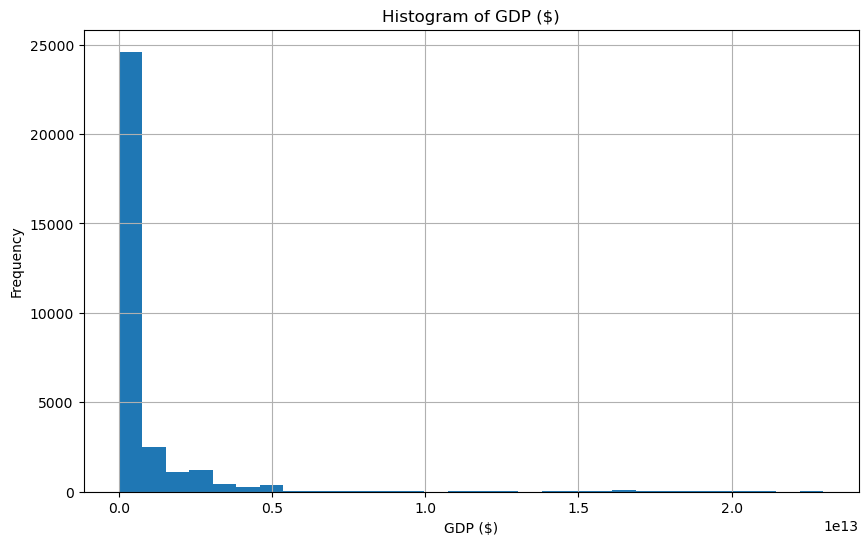

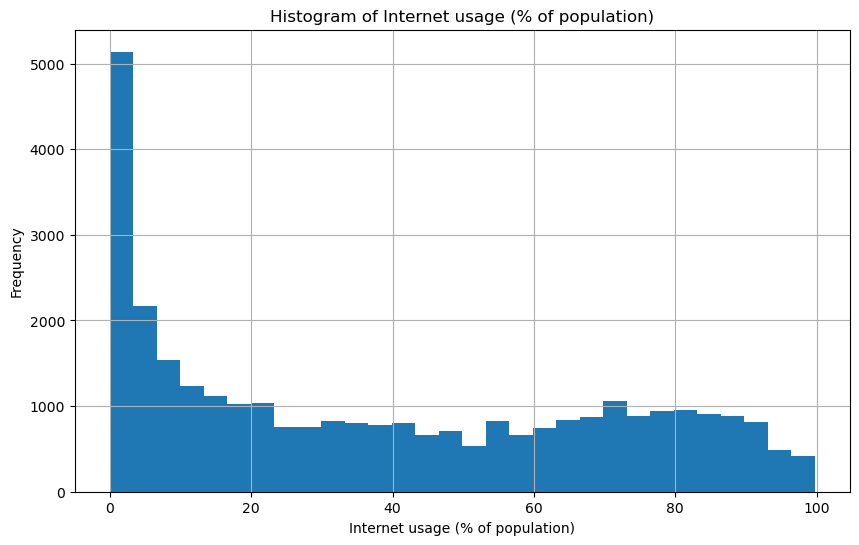

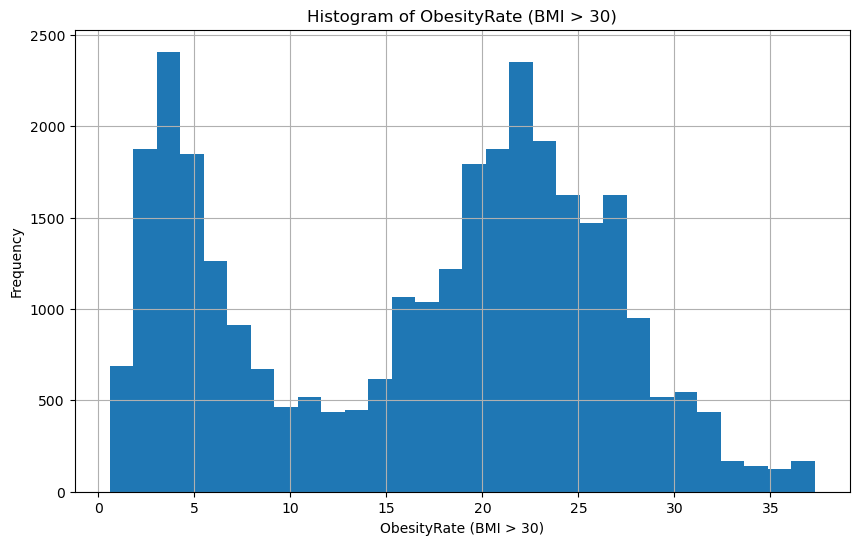

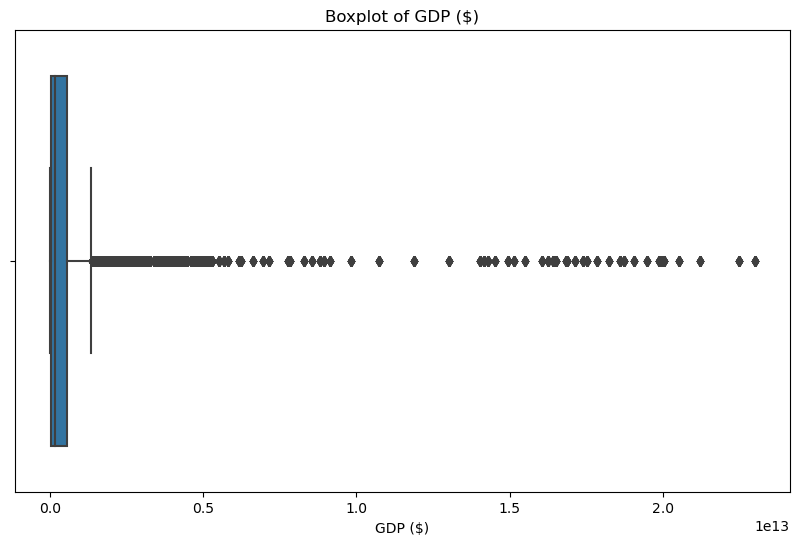

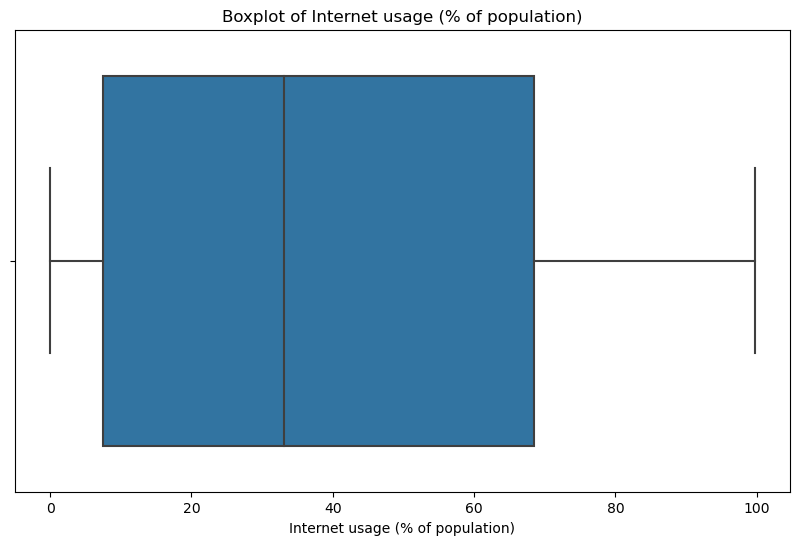

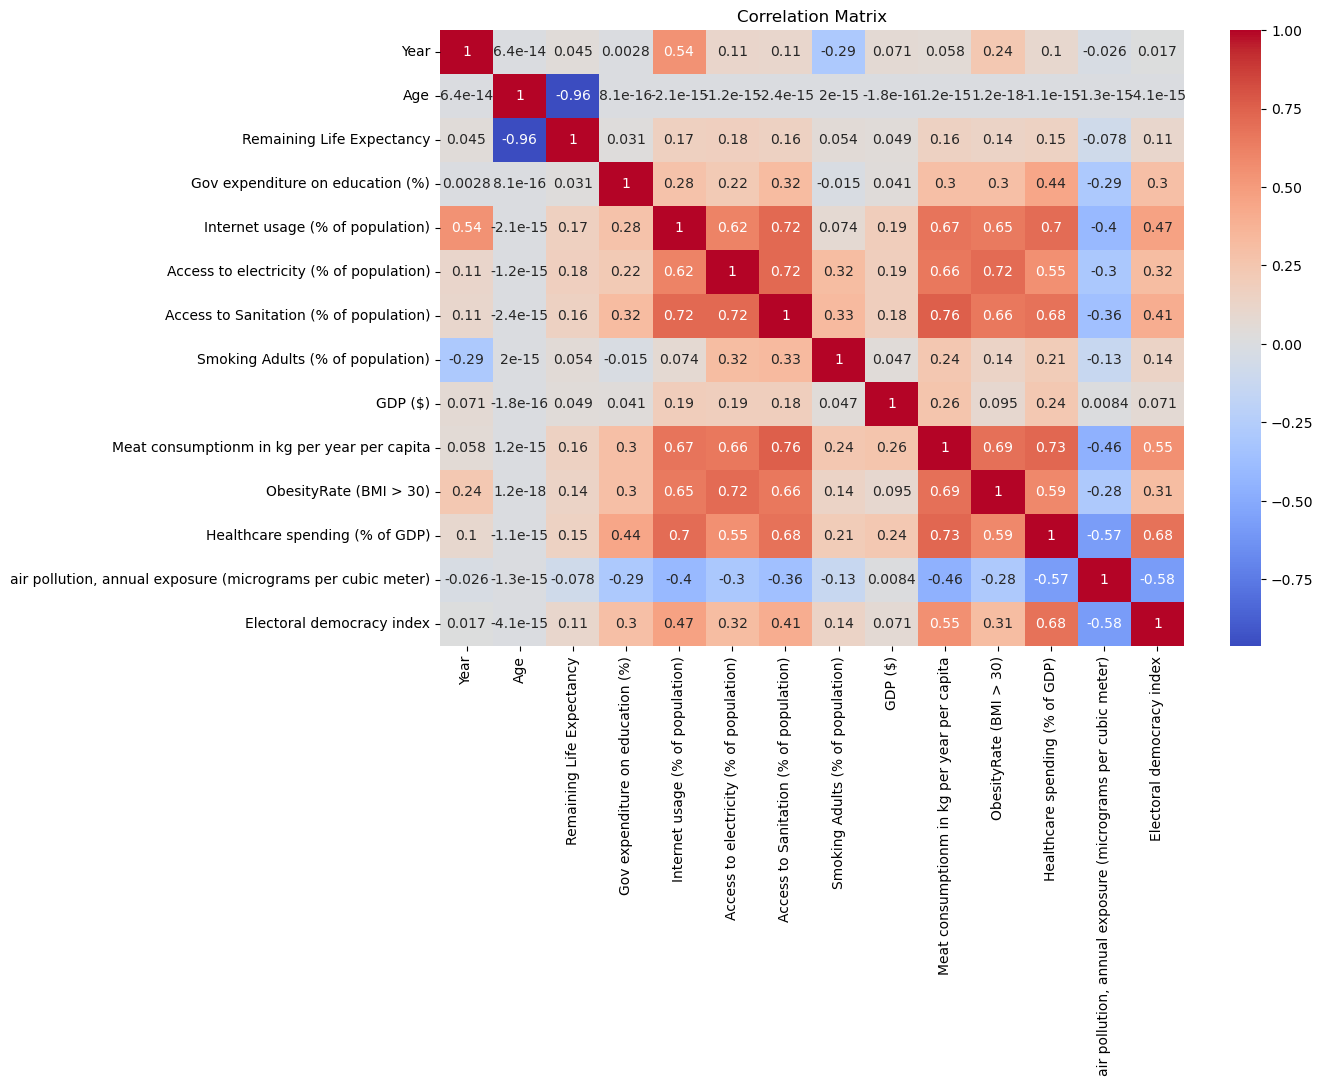

In [205]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
# Load the final merged dataset
final_df = pd.read_csv('final_merged_data.csv')
 
# Display basic descriptive statistics
print("Descriptive Statistics:")
print(final_df.describe())
 
# Histograms for selected columns
columns_to_visualize = ['GDP ($)', 'Internet usage (% of population)', 'ObesityRate (BMI > 30)']
for column in columns_to_visualize:
    plt.figure(figsize=(10, 6))
    final_df[column].hist(bins=30)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()
 
# Boxplots for potential outlier detection in specific columns
columns_for_outliers = ['GDP ($)', 'Internet usage (% of population)']
for column in columns_for_outliers:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=final_df[column])
    plt.title(f'Boxplot of {column}')
    plt.show()
 
# Correlation matrix (optional)
plt.figure(figsize=(12, 8))
# Update here: specify numeric_only=True
sns.heatmap(final_df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Feature Selection & Engineering

Korrelationen und welches sind wichtige features
binary encoding for categorial variables

In [206]:
# List of countries to be removed
countries_to_remove = [
    'United Arab Emirates', 'Cayman Islands', 'Suriname', 'Curacao', 'Turkmenistan',
    'South Sudan', 'Uzbekistan', 'Palestine', 'East Timor', 'Liberia', 'Vietnam', 'Nauru',
    'Serbia', 'American Samoa', 'Bahrain', 'Kosovo', 'Curacao', 'South Sudan', 'North Korea',
    'Liberia', 'South Sudan', 'Turks and Caicos Islands', 'Greenland', 'Channel Islands',
    'Montenegro', 'Djibouti', 'Somalia', 'Turks and Caicos Islands', 'Sint Maarten (Dutch part)',
    'Kosovo', 'Cayman Islands', 'Bahrain', 'Bhutan', 'Micronesia (country)', 'Nauru', 'Qatar',
    'South Sudan', 'Burundi', 'Sudan', 'Comoros', 'Democratic Republic of Congo', 'Libya',
    'Papua New Guinea', 'Seychelles', 'Syria', 'Montenegro', 'Serbia', 'South Sudan',
    'Montenegro', 'Zimbabwe'
]

# Remove rows with the specified countries
final_df = final_df[~final_df['Entity'].isin(countries_to_remove)]

final_df


Entity Code  Year     Sex  Age  Remaining Life Expectancy  \
0            Algeria  DZA  2000  Female    0                    71.9487   
1            Algeria  DZA  2001  Female    0                    72.1968   
2            Algeria  DZA  2002  Female    0                    72.5595   
3            Algeria  DZA  2003  Female    0                    72.2499   
4            Algeria  DZA  2004  Female    0                    72.8122   
...              ...  ...   ...     ...  ...                        ...   
31096  United States  USA  2016    Male   80                     8.7799   
31097  United States  USA  2017    Male   80                     8.7725   
31098  United States  USA  2018    Male   80                     8.8969   
31099  United States  USA  2019    Male   80                     9.0346   
31100  United States  USA  2020    Male   80                     8.2723   

       Gov expenditure on education (%)  Internet usage (% of population)  \
0                              4.982849                          0.491706   
1                              4.902120                          0.646114   
2                              4.821391                          1.591641   
3                              4.740663                          2.195360   
4                              4.659934                          4.634475   
...                                 ...                               ...   
31096                          4.806660                         85.544420   
31097                          5.122880                         87.274890   
31098                          4.928890                         88.498900   
31099                          4.987280                         89.430280   
31100                          5.435440                         90.900000   

       Access to electricity (% of population)  \
0                                     98.97310   
1                                     98.96687   
2                                     98.95306   
3                                     98.93401   
4                                     98.91208   
...                                        ...   
31096                                100.00000   
31097                                100.00000   
31098                                100.00000   
31099                                100.00000   
31100                                100.00000   

       Access to Sanitation (% of population)  \
0                                       58.85   
1                                       59.19   
2                                       59.53   
3                                       59.86   
4                                       60.18   
...                                       ...   
31096                                   97.19   
31097                                   97.16   
31098                                   97.14   
31099                                   97.11   
31100                                   97.09   

       Smoking Adults (% of population)       GDP ($)  \
0                             22.200000  2.703917e+11   
1                             22.120000  2.785034e+11   
2                             22.040000  2.940996e+11   
3                             21.960000  3.152748e+11   
4                             21.880000  3.288316e+11   
...                                 ...           ...   
31096                         24.666667  1.905248e+13   
31097                         24.033333  1.947962e+13   
31098                         23.400000  2.005337e+13   
31099                         23.400000  2.051348e+13   
31100                         23.000000  1.994571e+13   

       Meat consumptionm in kg per year per capita  ObesityRate (BMI > 30)  \
0                                        18.933718                    15.0   
1                                        17.341906                    15.5   
2                                        18.096855                    16.1   
3

#### Binary encoding

In [207]:

final_df2 = final_df.drop('Code', axis=1)
 
# Selected columns for binary encoding
columns_to_encode = ['Sex', 'Entity']
 
# Create a new DataFrame for training with binary encoding
encoder = ce.BinaryEncoder(cols=columns_to_encode, drop_invariant=True, return_df=True)

training_dataset = encoder.fit_transform(final_df2)
 
# Save the original column names before encoding
original_columns = encoder.get_feature_names_out()
 
# Save the result

training_dataset.to_csv('training_dataset_binary.csv', index=False)
 
# Back-encode to get the original DataFrame
original_df = encoder.inverse_transform(training_dataset[original_columns])
 
training_dataset

Entity_0  Entity_1  Entity_2  Entity_3  Entity_4  Entity_5  Entity_6  \
0             0         0         0         0         0         0         1   
1             0         0         0         0         0         0         1   
2             0         0         0         0         0         0         1   
3             0         0         0         0         0         0         1   
4             0         0         0         0         0         0         1   
...         ...       ...       ...       ...       ...       ...       ...   
31096         1         1         0         0         0         1         1   
31097         1         1         0         0         0         1         1   
31098         1         1         0         0         0         1         1   
31099         1         1         0         0         0         1         1   
31100         1         1         0         0         0         1         1   

       Year  Sex_0  Sex_1  ...  Internet usage (% of population)  \
0      2000      0      1  ...                          0.491706   
1      2001      0      1  ...                          0.646114   
2      2002      0      1  ...                          1.591641   
3      2003      0      1  ...                          2.195360   
4      2004      0      1  ...                          4.634475   
...     ...    ...    ...  ...                               ...   
31096  2016      1      0  ...                         85.544420   
31097  2017      1      0  ...                         87.274890   
31098  2018      1      0  ...                         88.498900   
31099  2019      1      0  ...                         89.430280   
31100  2020      1      0  ...                         90.900000   

       Access to electricity (% of population)  \
0                                     98.97310   
1                                     98.96687   
2                                     98.95306   
3                                     98.93401   
4                                     98.91208   
...                                        ...   
31096                                100.00000   
31097                                100.00000   
31098                                100.00000   
31099                                100.00000   
31100                                100.00000   

       Access to Sanitation (% of population)  \
0                                       58.85   
1                                       59.19   
2                                       59.53   
3                                       59.86   
4                                       60.18   
...                                       ...   
31096                                   97.19   
31097                                   97.16   
31098                                   97.14   
31099                                   97.11   
31100                                   97.09   

       Smoking Adults (% of population)       GDP ($)  \
0                             22.200000  2.703917e+11   
1                             22.120000  2.785034e+11   
2                             22.040000  2.940996e+11   
3                             21.960000  3.152748e+11   
4                             21.880000  3.288316e+11   
...                                 ...           ...   
31096                         24.666667  1.905248e+13   
31097                         24.033333  1.947962e+13   
31098                         23.400000  2.005337e+13   
31099                         23.400000  2.051348e+13   
31100                         23.000000  1.994571e+13   

       Meat consumptionm in kg per year per capita  ObesityRate (BMI > 30)  \
0                                        18.933718                    15.0   
1                                        17.341906                    15.5   
2                                        18.096855                    16.1   
3                                        19.324575    

#### onehot encoding

In [208]:
final_df2 = final_df.drop('Code', axis=1)

# Selected columns for one-hot encoding
columns_to_encode = ['Sex', 'Entity']

# Create a new DataFrame for training with one-hot encoding
encoder = ce.OneHotEncoder(cols=columns_to_encode, use_cat_names=True)

training_dataset_onehot = encoder.fit_transform(final_df2)

# Save the result as CSV
training_dataset_onehot.to_csv('training_dataset_onehot.csv', index=False)

training_dataset_onehot

Entity_Algeria  Entity_Argentina  Entity_Armenia  Entity_Australia  \
0                   1                 0               0                 0   
1                   1                 0               0                 0   
2                   1                 0               0                 0   
3                   1                 0               0                 0   
4                   1                 0               0                 0   
...               ...               ...             ...               ...   
31096               0                 0               0                 0   
31097               0                 0               0                 0   
31098               0                 0               0                 0   
31099               0                 0               0                 0   
31100               0                 0               0                 0   

       Entity_Austria  Entity_Azerbaijan  Entity_Bangladesh  Entity_Belarus  \
0                   0                  0                  0               0   
1                   0                  0                  0               0   
2                   0                  0                  0               0   
3                   0                  0                  0               0   
4                   0                  0                  0               0   
...               ...                ...                ...             ...   
31096               0                  0                  0               0   
31097               0                  0                  0               0   
31098               0                  0                  0               0   
31099               0                  0                  0               0   
31100               0                  0                  0               0   

       Entity_Belgium  Entity_Benin  ...  Internet usage (% of population)  \
0                   0             0  ...                          0.491706   
1                   0             0  ...                          0.646114   
2                   0             0  ...                          1.591641   
3                   0             0  ...                          2.195360   
4                   0             0  ...                          4.634475   
...               ...           ...  ...                               ...   
31096               0             0  ...                         85.544420   
31097               0             0  ...                         87.274890   
31098               0             0  ...                         88.498900   
31099               0             0  ...                         89.430280   
31100               0             0  ...                         90.900000   

       Access to electricity (% of population)  \
0                                     98.97310   
1                                     98.96687   
2                                     98.95306   
3                                     98.93401   
4                                     98.91208   
...                                        ...   
31096                                100.00000   
31097                                100.00000   
31098                                100.00000   
31099                                100.00000   
31100                                100.00000   

       Access to Sanitation (% of population)  \
0                                       58.85   
1                                       59.19   
2                                       59.53   
3                                       59.86   
4                                       60.18   
...                                       ...   
31096                                   97.19   
31097                                   97.16   
31098                                   97.14   
31099                                   97.11   
31100                                   97.09   

      

### List the encodings

In [209]:
# Extract binary encoded 'Entity' columns
binary_encoded_entities = training_dataset.filter(regex='^Entity_')

# Retrieve the original 'Entity' values from the back-encoded DataFrame
original_entities = original_df['Entity']

# Create a DataFrame that pairs each original 'Entity' with its binary encoding
entity_binary_encoding = pd.concat([original_entities, binary_encoded_entities], axis=1).drop_duplicates()

# Convert the DataFrame to a list of tuples for easier reading
entity_binary_encoding_list = list(entity_binary_encoding.itertuples(index=False, name=None))

# Print the list to see the original 'Entity' and their binary encodings
for item in entity_binary_encoding_list:
    print(item)




('Algeria', 0, 0, 0, 0, 0, 0, 1)
('Argentina', 0, 0, 0, 0, 0, 1, 0)
('Armenia', 0, 0, 0, 0, 0, 1, 1)
('Australia', 0, 0, 0, 0, 1, 0, 0)
('Austria', 0, 0, 0, 0, 1, 0, 1)
('Azerbaijan', 0, 0, 0, 0, 1, 1, 0)
('Bangladesh', 0, 0, 0, 0, 1, 1, 1)
('Belarus', 0, 0, 0, 1, 0, 0, 0)
('Belgium', 0, 0, 0, 1, 0, 0, 1)
('Benin', 0, 0, 0, 1, 0, 1, 0)
('Brazil', 0, 0, 0, 1, 0, 1, 1)
('Bulgaria', 0, 0, 0, 1, 1, 0, 0)
('Burkina Faso', 0, 0, 0, 1, 1, 0, 1)
('Cambodia', 0, 0, 0, 1, 1, 1, 0)
('Canada', 0, 0, 0, 1, 1, 1, 1)
('Chad', 0, 0, 1, 0, 0, 0, 0)
('Chile', 0, 0, 1, 0, 0, 0, 1)
('China', 0, 0, 1, 0, 0, 1, 0)
('Colombia', 0, 0, 1, 0, 0, 1, 1)
('Costa Rica', 0, 0, 1, 0, 1, 0, 0)
("Cote d'Ivoire", 0, 0, 1, 0, 1, 0, 1)
('Croatia', 0, 0, 1, 0, 1, 1, 0)
('Cyprus', 0, 0, 1, 0, 1, 1, 1)
('Czechia', 0, 0, 1, 1, 0, 0, 0)
('Denmark', 0, 0, 1, 1, 0, 0, 1)
('Dominican Republic', 0, 0, 1, 1, 0, 1, 0)
('Ecuador', 0, 0, 1, 1, 0, 1, 1)
('Egypt', 0, 0, 1, 1, 1, 0, 0)
('Estonia', 0, 0, 1, 1, 1, 0, 1)
('Ethiopia', 0, 0, 

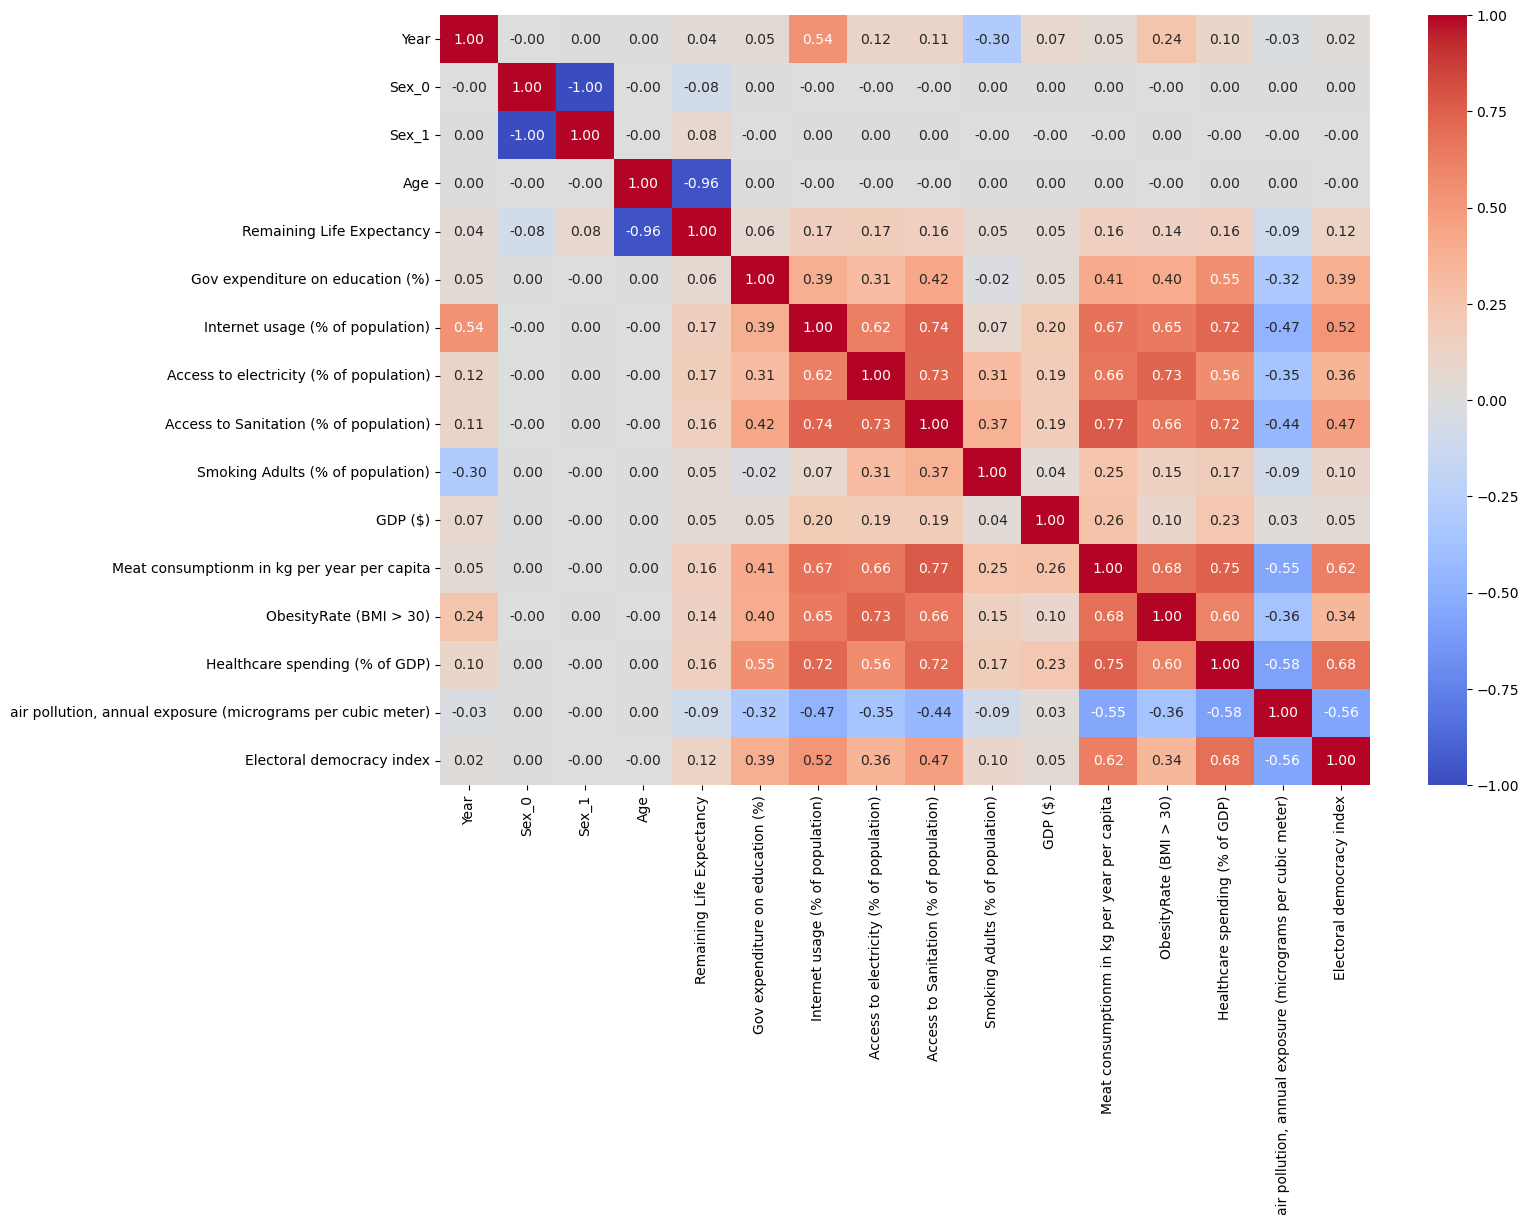

In [210]:
# Exclude columns 'Entity_0' to 'Entity_6' from the correlation matrix
columns_to_exclude = [f'Entity_{i}' for i in range(7)]  # Assuming you have 'Entity_0' to 'Entity_6'
correlation_matrix = training_dataset.drop(columns=columns_to_exclude).corr()

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Show the plot
plt.show()
#    0 to 0.2: Very weak correlation
#    0.2 to 0.4: Weak correlation
#    0.4 to 0.6: Moderate correlation
#    0.6 to 0.8: Strong correlation
#    0.8 to 1.0: Very strong correlation

# Anwendung in Machine Learning

#### Linear regression SGD

In [222]:
import shap
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

def train_and_evaluate(dataset_filename):
    # Load the dataset
    data = pd.read_csv(dataset_filename)

    # Splitting the data
    X = data.drop('Remaining Life Expectancy', axis=1)
    y = data['Remaining Life Expectancy']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardizing the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Creating and training the SGD Regressor
    sgd_reg = SGDRegressor(random_state=42)
    sgd_reg.fit(X_train_scaled, y_train)

    # Predictions and Evaluation
    y_pred = sgd_reg.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    return {
        'model': sgd_reg,
        'X_train_scaled': X_train_scaled,
        'X_test_scaled': X_test_scaled,
        'metrics': {'RMSE': rmse, 'R2': r2},
        'feature_names': X.columns 
    }

# Running the function for both datasets
results_binary = train_and_evaluate('training_dataset_binary.csv')
results_onehot = train_and_evaluate('training_dataset_onehot.csv')


# Printing results and saving metrics
metrics = {
    'sgd_binary': results_binary['metrics'],
    'sgd_onehot': results_onehot['metrics']
}
#SGD ANPASSEN
print(f"Metrics for Binary Encoded Data: {metrics['sgd_binary']}")
print(f"Metrics for One-Hot Encoded Data: {metrics['sgd_onehot']}")

Metrics for Binary Encoded Data: {'RMSE': 3.7816978241830657, 'R2': 0.974495854804723}
Metrics for One-Hot Encoded Data: {'RMSE': 3.2676450728971567, 'R2': 0.98095824904745}


#### XGBoost

In [223]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib

def train_and_evaluate_xgb(dataset_filename):
    # Load the dataset
    data = pd.read_csv(dataset_filename)

    # Separate the features and the target variable
    X = data.drop('Remaining Life Expectancy', axis=1)
    y = data['Remaining Life Expectancy']

    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the XGBoost regressor
    model = xgb.XGBRegressor(objective='reg:squarederror')

    # Train the model
    model.fit(X_train, y_train)

    # Predict and evaluate the model
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)

    return {
        'model': model,
        'X_train': X_train,
        'X_test': X_test,
        'metrics': {'RMSE': rmse, 'R2': r2}
    }

# Running the function for the binary dataset
xgb_results_binary = train_and_evaluate_xgb('training_dataset_binary.csv')

# Save the binary model
joblib.dump(xgb_results_binary['model'], 'frontend/xgb_model_binary.joblib')

# Running the function for the one-hot dataset
xgb_results_onehot = train_and_evaluate_xgb('training_dataset_onehot.csv')


# Printing only the metrics
print("XGBoost Metrics:")
print(f"Binary Encoded Data: RMSE = {xgb_results_binary['metrics']['RMSE']}, R2 = {xgb_results_binary['metrics']['R2']}")
print(f"One-Hot Encoded Data: RMSE = {xgb_results_onehot['metrics']['RMSE']}, R2 = {xgb_results_onehot['metrics']['R2']}")

# Adding XGBoost metrics to the metrics dictionary
metrics['xgboost_binary'] = xgb_results_binary['metrics']
metrics['xgboost_onehot'] = xgb_results_onehot['metrics']


XGBoost Metrics:
Binary Encoded Data: RMSE = 0.6732615972719469, R2 = 0.9991916400078902
One-Hot Encoded Data: RMSE = 0.6703531866809824, R2 = 0.9991986089621817


#### Random Forest

In [224]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def train_and_evaluate_rf(dataset_filename):
    # Load the dataset
    data = pd.read_csv(dataset_filename)

    # Separate the features and the target variable
    X = data.drop('Remaining Life Expectancy', axis=1)
    y = data['Remaining Life Expectancy']

    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the Random Forest Regressor
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X_train, y_train)

    # Predict and evaluate the model
    y_pred = rf_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
   
    return {
        'model': rf_model,
        'X': X,
        'y': y,
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'metrics': {'RMSE': rmse, 'R2': r2}
    }

# Running the function for both datasets
rf_metrics_binary = train_and_evaluate_rf('training_dataset_binary.csv')
rf_metrics_onehot = train_and_evaluate_rf('training_dataset_onehot.csv')
 
# Printing only the metrics
print("Random Forest Metrics:")
print(f"Binary Encoded Data: RMSE = {rf_metrics_binary['metrics']['RMSE']}, R2 = {rf_metrics_binary['metrics']['R2']}")
print(f"One-Hot Encoded Data: RMSE = {rf_metrics_onehot['metrics']['RMSE']}, R2 = {rf_metrics_onehot['metrics']['R2']}")
 
# Adding Random Forest metrics to the metrics dictionary
metrics['rf_binary'] = rf_metrics_binary['metrics']
metrics['rf_onehot'] = rf_metrics_onehot['metrics']

Random Forest Metrics:
Binary Encoded Data: RMSE = 0.6687998531559722, R2 = 0.9992023186046252
One-Hot Encoded Data: RMSE = 0.63848720676795, R2 = 0.9992729880919071


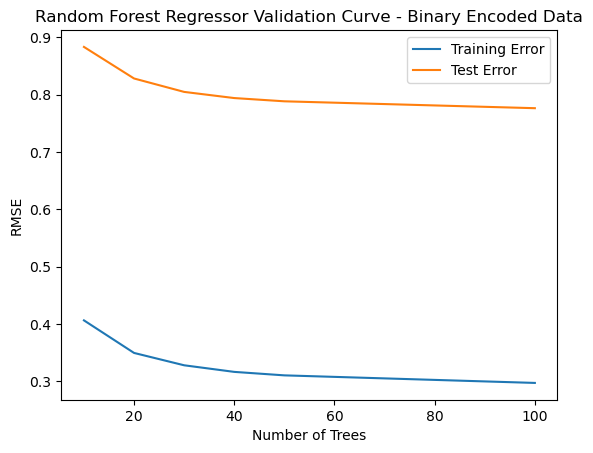

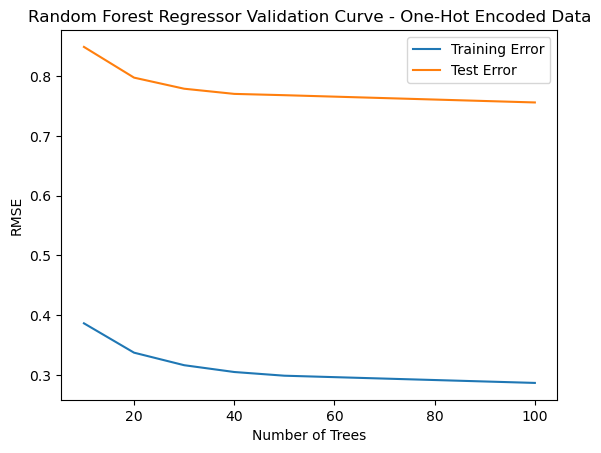

In [214]:
from sklearn.model_selection import validation_curve

def plot_validation_curve(X_train, y_train, title_suffix):
    param_range = [10, 20, 30, 40, 50, 100]
    train_scores, test_scores = validation_curve(
        RandomForestRegressor(random_state=42), X_train, y_train, param_name='n_estimators', param_range=param_range,
        cv=5, scoring='neg_mean_squared_error'
    )

    # Convert from negative MSE to RMSE
    train_mean = np.sqrt(-np.mean(train_scores, axis=1))
    test_mean = np.sqrt(-np.mean(test_scores, axis=1))

    # Plotting the validation curve
    plt.plot(param_range, train_mean, label='Training Error')
    plt.plot(param_range, test_mean, label='Test Error')
    plt.xlabel('Number of Trees')
    plt.ylabel('RMSE')
    plt.title(f'Random Forest Regressor Validation Curve - {title_suffix}')
    plt.legend()
    plt.show()

# Running the function for both datasets
rf_results_binary = train_and_evaluate_rf('training_dataset_binary.csv')
rf_results_onehot = train_and_evaluate_rf('training_dataset_onehot.csv')

# Plotting validation curves for both datasets
plot_validation_curve(rf_results_binary['X_train'], rf_results_binary['y_train'], 'Binary Encoded Data')
plot_validation_curve(rf_results_onehot['X_train'], rf_results_onehot['y_train'], 'One-Hot Encoded Data')

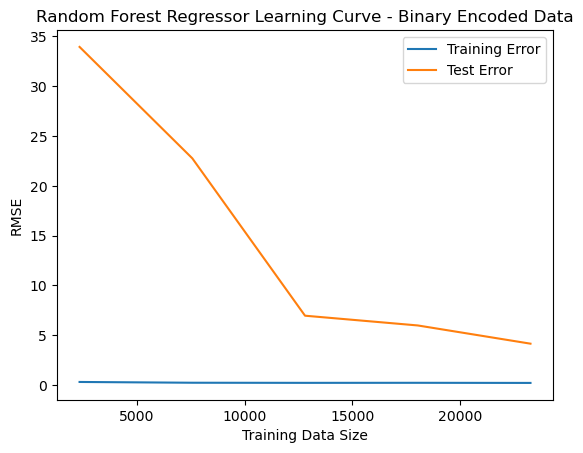

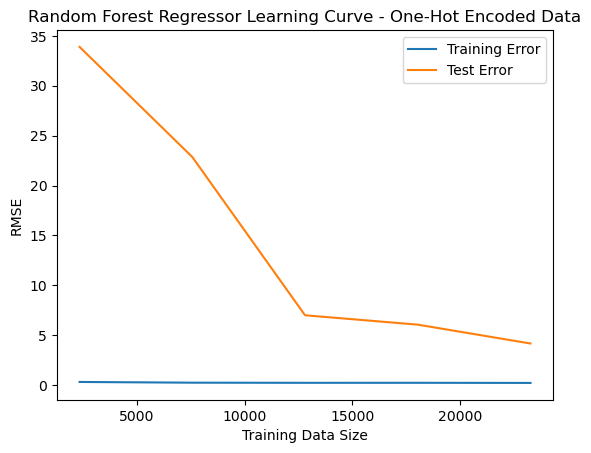

In [215]:
from sklearn.model_selection import learning_curve
 
def plot_learning_curve(model, X, y, title_suffix):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='neg_mean_squared_error'
    )

    # Convert from negative MSE to RMSE
    train_mean = np.sqrt(-np.mean(train_scores, axis=1))
    test_mean = np.sqrt(-np.mean(test_scores, axis=1))

    # Plotting the learning curve
    plt.plot(train_sizes, train_mean, label='Training Error')
    plt.plot(train_sizes, test_mean, label='Test Error')
    plt.xlabel('Training Data Size')
    plt.ylabel('RMSE')
    plt.title(f'Random Forest Regressor Learning Curve - {title_suffix}')
    plt.legend()
    plt.show()

# Plotting learning curves for both datasets
plot_learning_curve(rf_results_binary['model'], rf_results_binary['X'], rf_results_binary['y'], 'Binary Encoded Data')
plot_learning_curve(rf_results_onehot['model'], rf_results_onehot['X'], rf_results_onehot['y'], 'One-Hot Encoded Data')

#### Feedforward Network

In [232]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

torch.manual_seed(42)

class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

def train_and_evaluate_nn(dataset_filename, save_model=False):
    # Load the dataset
    data = pd.read_csv(dataset_filename)  

    # Separate the features and the target variable
    X = data.drop('Remaining Life Expectancy', axis=1).values
    y = data['Remaining Life Expectancy'].values

    # Standardize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32)

    # Create PyTorch datasets and DataLoaders
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

    # Model, Loss, and Optimizer
    model = NeuralNet(X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Early stopping parameters
    patience = 20
    best_loss = float('inf')
    epochs_no_improve = 0

    # Training the Model
    num_epochs = 200
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()  # Training mode
        train_loss = 0
        for inputs, targets in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()  # Evaluation mode
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}')

        # Check for early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f'Early stopping triggered after {epoch+1} epochs!')
            break

    # Evaluate the model on test set
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    y_test_pred = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            test_loss += loss.item()
            y_test_pred.extend(outputs.numpy().squeeze())

    avg_test_loss = test_loss / len(test_loader)
    rmse = np.sqrt(avg_test_loss)
    r2 = r2_score(y_test, y_test_pred)

    # Save the model and scaler
    if save_model:
        joblib.dump(scaler, 'frontend/scaler.save')
        torch.save(model.state_dict(), 'frontend/FNN_model.pth')

    # Return the losses, metrics, and test_loader
    return {
        'metrics': {'RMSE': rmse, 'R2': r2}, 
        'train_losses': train_losses, 
        'val_losses': val_losses, 
        'test_loader': test_loader,
        'model': model
    }


# Running the function for both datasets
nn_metrics_binary = train_and_evaluate_nn('training_dataset_binary.csv', save_model=True)
nn_metrics_onehot = train_and_evaluate_nn('training_dataset_onehot.csv')

# Extract the trained model
model_binary = nn_metrics_binary['model']
model_onehot = nn_metrics_onehot['model']

# Test loaders for SHAP analysis
test_loader_binary = nn_metrics_binary['test_loader']
test_loader_onehot = nn_metrics_onehot['test_loader']

# Printing results
print("Neural Network Metrics:")
print(f"Binary Encoded Data: RMSE = {nn_metrics_binary['metrics']}")
print(f"One-Hot Encoded Data: RMSE = {nn_metrics_onehot['metrics']}")

# Adding Neural Network metrics to the existing metrics dictionary
metrics['nn_binary'] = nn_metrics_binary['metrics'] 
metrics['nn_onehot'] = nn_metrics_onehot['metrics']



Epoch [1/200], Validation Loss: 12.1415
Epoch [2/200], Validation Loss: 5.2597
Epoch [3/200], Validation Loss: 3.3735
Epoch [4/200], Validation Loss: 2.6181
Epoch [5/200], Validation Loss: 2.0885
Epoch [6/200], Validation Loss: 1.7358
Epoch [7/200], Validation Loss: 1.4270
Epoch [8/200], Validation Loss: 1.2207
Epoch [9/200], Validation Loss: 1.1486
Epoch [10/200], Validation Loss: 0.9692
Epoch [11/200], Validation Loss: 1.0052
Epoch [12/200], Validation Loss: 0.8481
Epoch [13/200], Validation Loss: 0.8344
Epoch [14/200], Validation Loss: 0.7461
Epoch [15/200], Validation Loss: 0.8868
Epoch [16/200], Validation Loss: 0.6935
Epoch [17/200], Validation Loss: 0.7261
Epoch [18/200], Validation Loss: 0.8180
Epoch [19/200], Validation Loss: 0.6401
Epoch [20/200], Validation Loss: 0.6284
Epoch [21/200], Validation Loss: 0.5347
Epoch [22/200], Validation Loss: 0.5049
Epoch [23/200], Validation Loss: 0.4671
Epoch [24/200], Validation Loss: 0.5474
Epoch [25/200], Validation Loss: 0.5367
Epoch [2

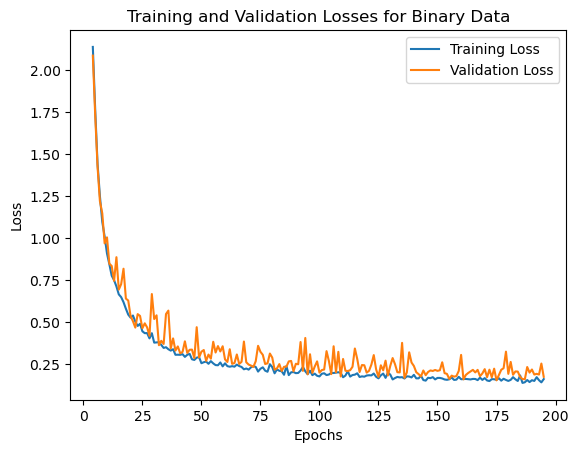

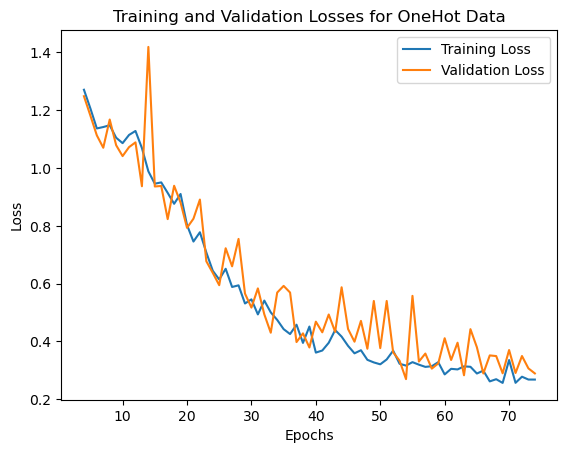

In [217]:
# Plotting the training and validation losses
plt.plot(range(4, len(nn_metrics_binary['train_losses'])), nn_metrics_binary['train_losses'][4:], label='Training Loss')
plt.plot(range(4, len(nn_metrics_binary['val_losses'])), nn_metrics_binary['val_losses'][4:], label='Validation Loss')
plt.title('Training and Validation Losses for Binary Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation losses
plt.plot(range(4, len(nn_metrics_onehot['train_losses'])), nn_metrics_onehot['train_losses'][4:], label='Training Loss')
plt.plot(range(4, len(nn_metrics_onehot['val_losses'])), nn_metrics_onehot['val_losses'][4:], label='Validation Loss')
plt.title('Training and Validation Losses for OneHot Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Vergleich der Modelle

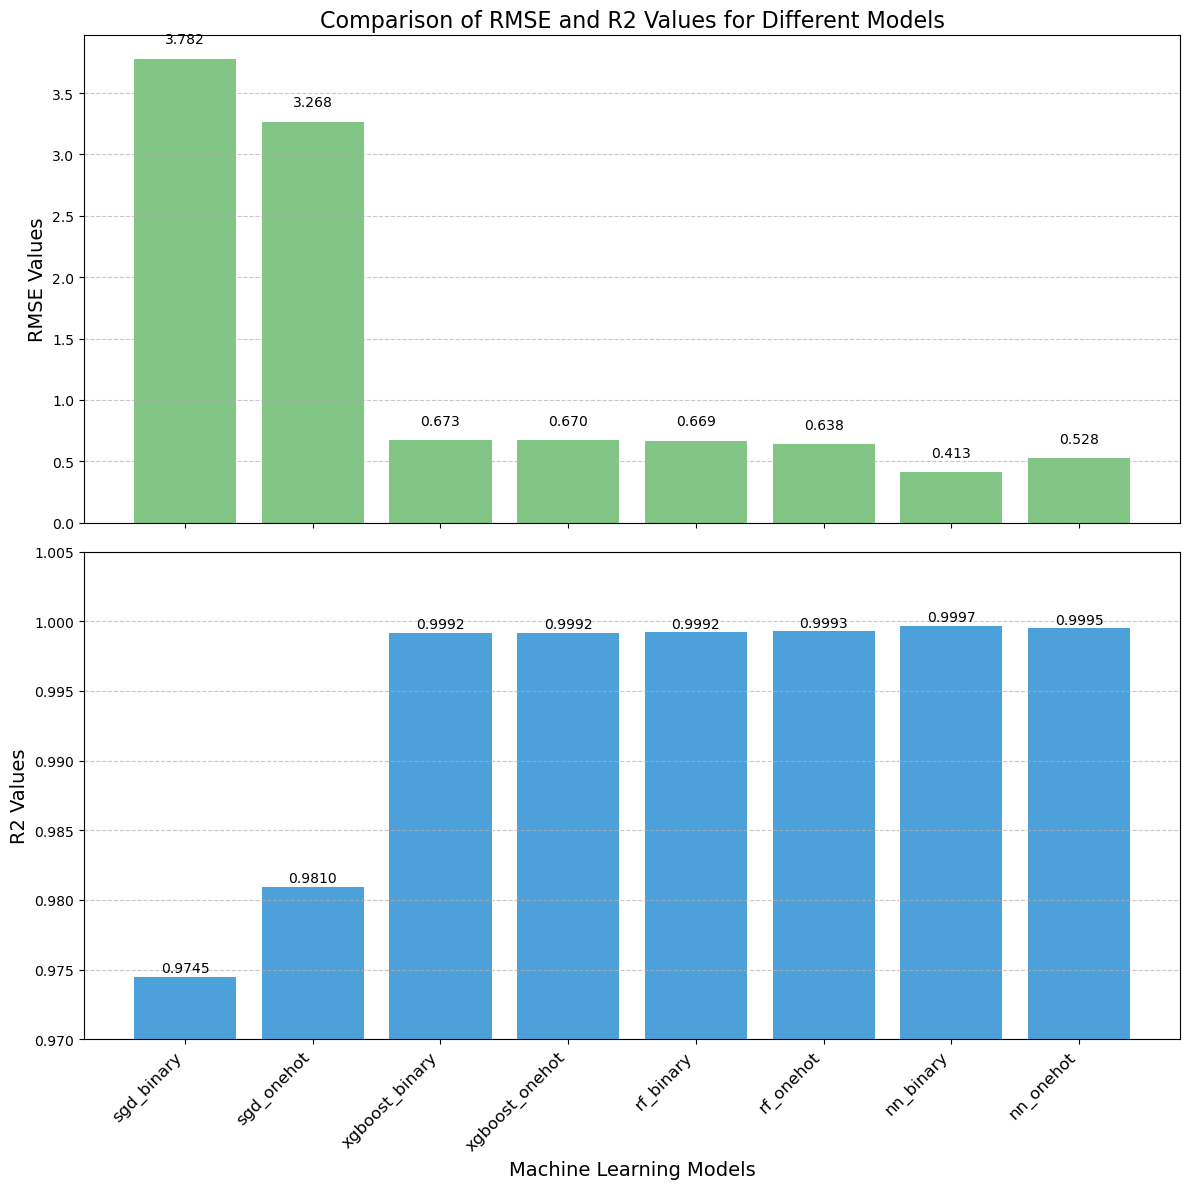

In [231]:
# Extract models, RMSE, and R2 values
models = list(metrics.keys())
rmse_values = [metrics[model]['RMSE'] for model in models]
r2_values = [metrics[model]['R2'] for model in models]
 
# Create two subplots (for RMSE and R2)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
 
# Plot for RMSE values
ax1.bar(models, rmse_values, color='#4CAF50', alpha=0.7)
ax1.set_ylabel('RMSE Values', fontsize=14)
ax1.set_title('Comparison of RMSE and R2 Values for Different Models', fontsize=16)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
 
# Add RMSE values above the bars
for i, value in enumerate(rmse_values):
    ax1.text(i, value + 0.1, f'{value:.3f}', ha='center', va='bottom', fontsize=10, color='black')
 
# Plot for R2 values
ax2.bar(models, r2_values, color='#007ACC', alpha=0.7)
ax2.set_xlabel('Machine Learning Models', fontsize=14)
ax2.set_ylabel('R2 Values', fontsize=14)
ax2.set_ylim(min(r2_values) - 0.001, max(r2_values) + 0.001)  # Adjust y-axis limits for better scaling
ax2.set_yticks([round(value, 4) for value in ax2.get_yticks()])  # Adjust y-axis ticks for better precision
ax2.grid(axis='y', linestyle='--', alpha=0.7)
 
# Add R2 values above the bars
for i, value in enumerate(r2_values):
    ax2.text(i, value + 0.0001, f'{value:.4f}', ha='center', va='bottom', fontsize=10, color='black')
 
# Show the plots
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()

# Anwendung von XAI – Techniken

##### SDG Regression

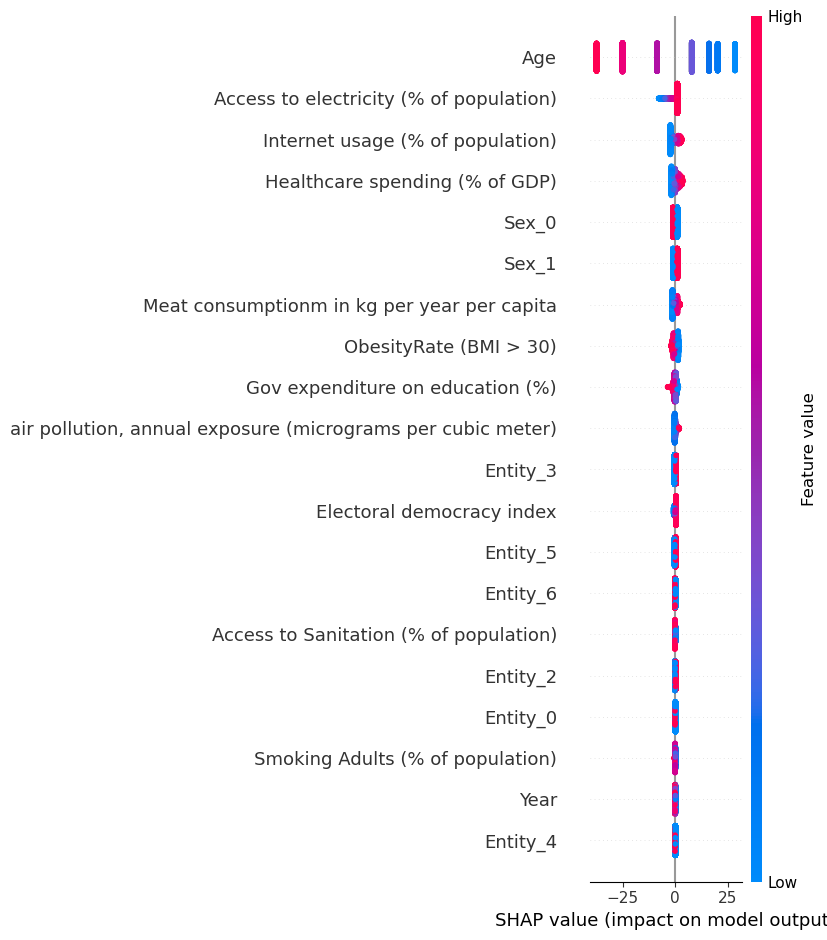

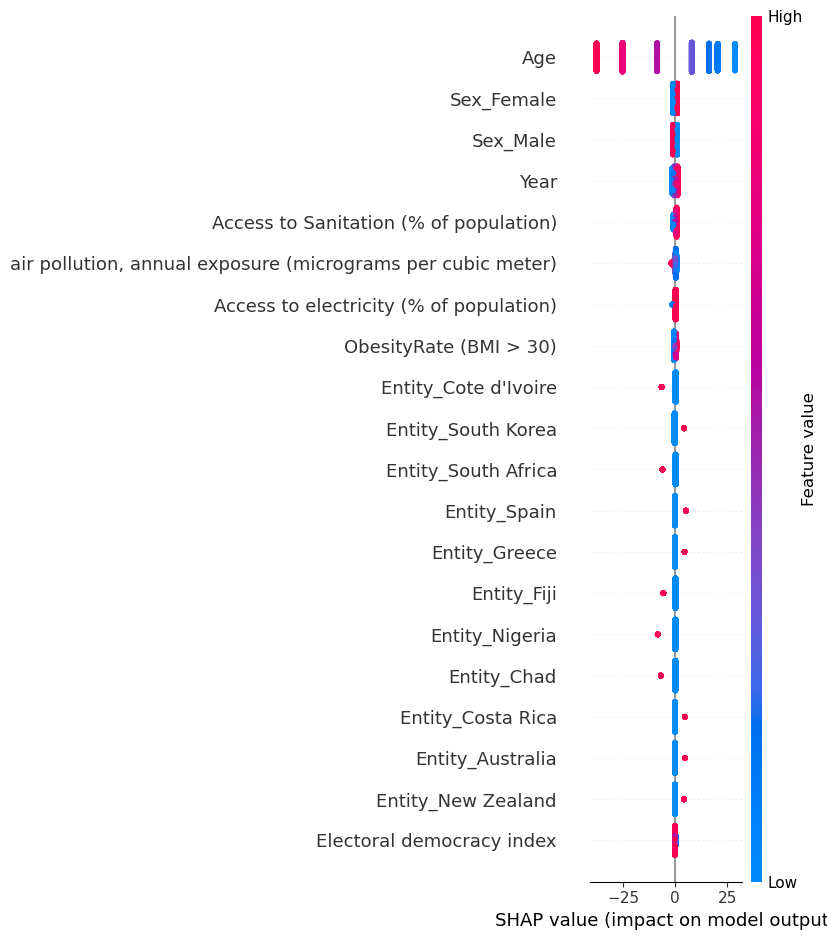

In [ ]:
# Creating SHAP explainers
explainer_binary_reg = shap.Explainer(results_binary['model'], results_binary['X_train_scaled'])
shap_values_binary_reg = explainer_binary_reg(results_binary['X_test_scaled'])

explainer_onehot_reg = shap.Explainer(results_onehot['model'], results_onehot['X_train_scaled'])
shap_values_onehot_reg = explainer_onehot_reg(results_onehot['X_test_scaled'])


# Visualizing SHAP values
shap.summary_plot(shap_values_binary_reg, results_binary['X_test_scaled'], feature_names=results_binary['feature_names'])
shap.summary_plot(shap_values_onehot_reg, results_onehot['X_test_scaled'], feature_names=results_onehot['feature_names'])

##### XGBoost

[12:03:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[12:03:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[12:03:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


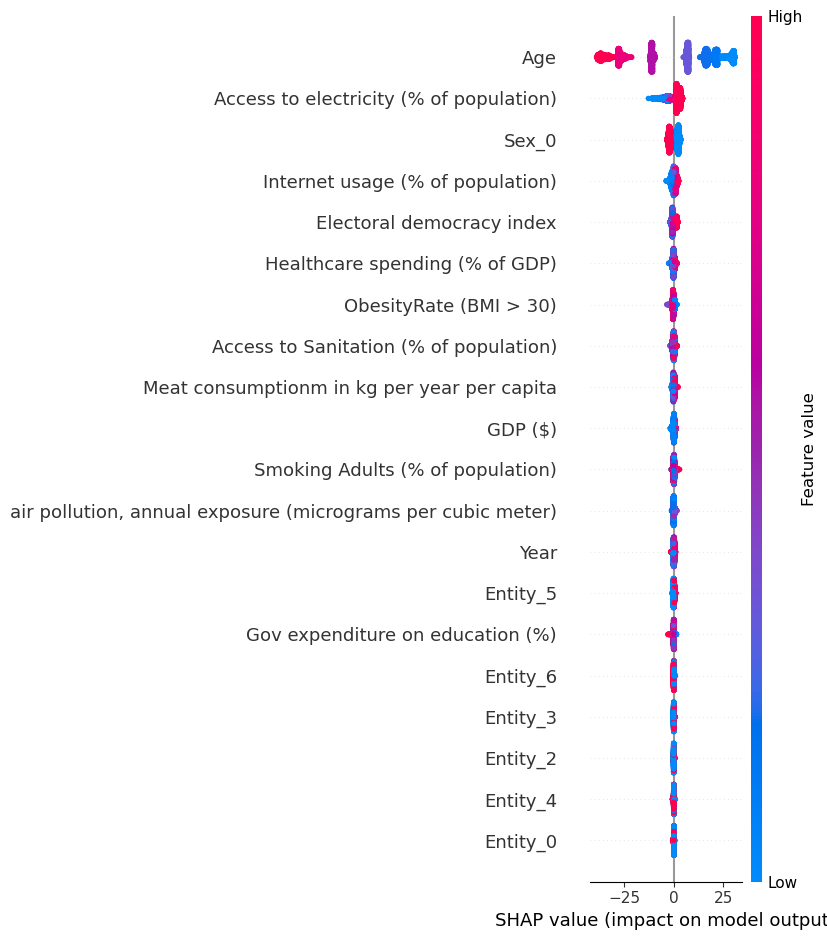

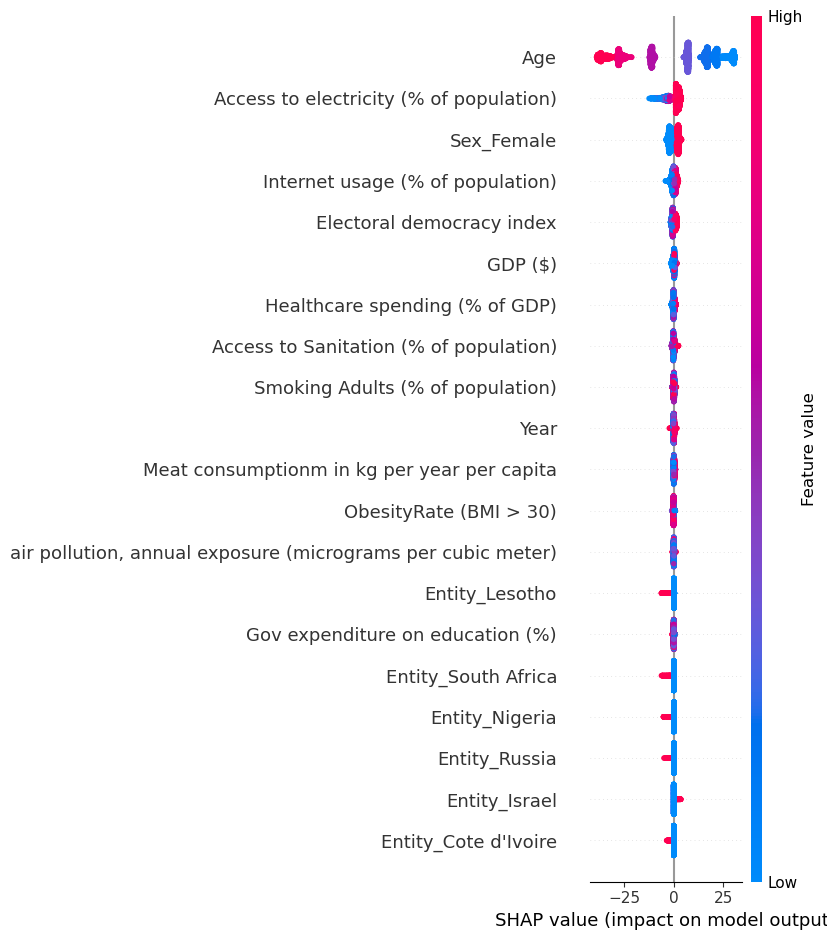

In [ ]:
# Running the function for both datasets
results_xgb_binary = train_and_evaluate_xgb('training_dataset_binary.csv')
results_xgb_onehot = train_and_evaluate_xgb('training_dataset_onehot.csv')

# Creating SHAP explainers for XGBoost models
explainer_xgb_binary = shap.Explainer(results_xgb_binary['model'])
shap_values_xgb_binary = explainer_xgb_binary(results_xgb_binary['X_test'])

explainer_xgb_onehot = shap.Explainer(results_xgb_onehot['model'])
shap_values_xgb_onehot = explainer_xgb_onehot(results_xgb_onehot['X_test'])

# Visualizing SHAP values
shap.summary_plot(shap_values_xgb_binary, results_xgb_binary['X_test'])
shap.summary_plot(shap_values_xgb_onehot, results_xgb_onehot['X_test'])


##### Random Forest

100%|===================| 5814/5822 [13:58<00:01]        

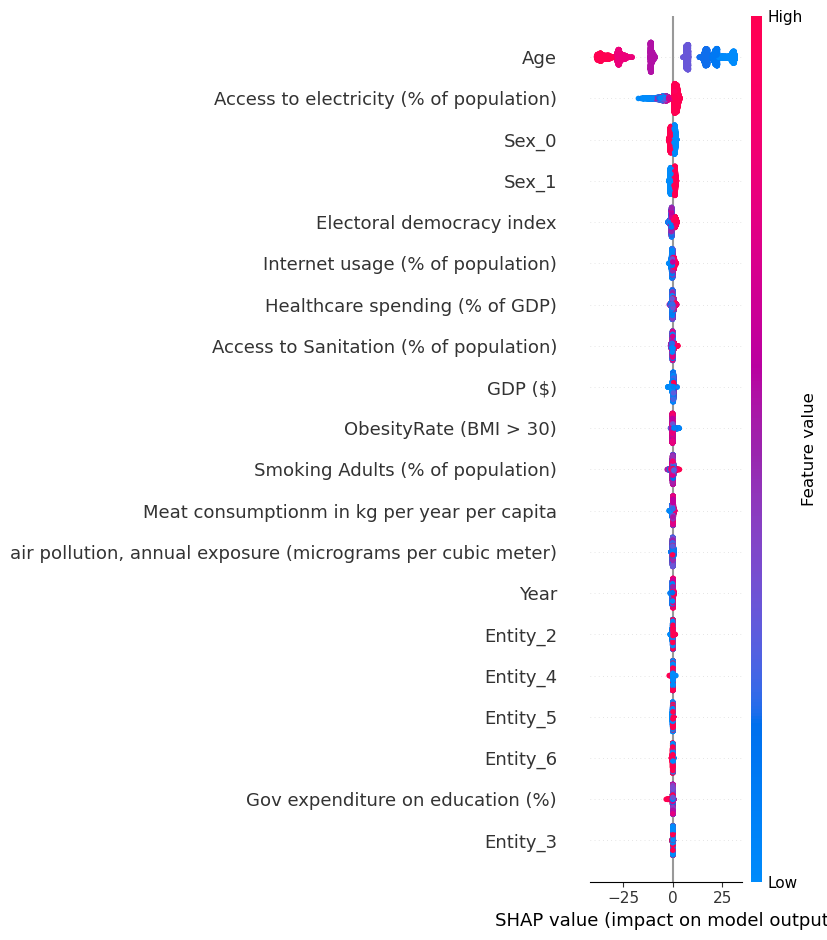

In [219]:
def create_rf_shap_explainer(model, X_train):
    """ Function to create a SHAP explainer for the Random Forest model """
    explainer = shap.Explainer(model, X_train)
    return explainer

# Choose the dataset for SHAP analysis (binary or one-hot encoded)
rf_model_for_shap = rf_metrics_binary['model']  # or rf_metrics_onehot['model']
X_train_for_shap = rf_metrics_binary['X_train']  # or rf_metrics_onehot['X_train']
X_test_for_shap = rf_metrics_binary['X_test']  # or rf_metrics_onehot['X_test']

# Create SHAP explainer for the Random Forest model
explainer_rf = create_rf_shap_explainer(rf_model_for_shap, X_train_for_shap)

# Calculate SHAP values for the test dataset
shap_values_rf = explainer_rf(X_test_for_shap)

# Visualization of SHAP values
shap.summary_plot(shap_values_rf, X_test_for_shap)

##### FNN

Kernel explainer instead of DeepExplainer, easier and faster

In [1]:
import shap
import torch
import numpy as np


# load  data into a Pandas DataFrame for feature names
data = pd.read_csv('training_dataset_binary.csv')

# Extract feature names
feature_names = data.drop('Remaining Life Expectancy', axis=1).columns.tolist()

# Function to make predictions from your neural network model
def model_predict(data):
    # Ensure data is a torch tensor
    data = torch.tensor(data, dtype=torch.float32)
    model_binary.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        predictions = model_binary(data).numpy()  # Get predictions
    return predictions

# background dataset (could be a smaller random sample)
background_data = torch.cat([batch[0] for batch in test_loader_binary], dim=0).numpy()
background_sample = background_data[np.random.choice(background_data.shape[0], 1000, replace=False)]

# Create the SHAP explainer using KernelExplainer
explainer = shap.KernelExplainer(model_predict, background_sample)

# Calculate SHAP values for a sample of your test data
X_test_sample = background_data[:1000]  # Adjust this as needed
shap_values = explainer.shap_values(X_test_sample)

# Visualization in Jupyter Notebook
shap.initjs()

# Select the correct SHAP values array for single-output models
shap_values_instance = shap_values[0] if isinstance(shap_values, list) else shap_values

# If X_test_sample is a tensor, convert it to a NumPy array
x_test_sample_array = X_test_sample.numpy() if torch.is_tensor(X_test_sample) else X_test_sample

# For the summary plot
shap.summary_plot(shap_values_instance, x_test_sample_array, feature_names=feature_names)





NameError: name 'pd' is not defined